# Analytics tables for i94 immigration dataset in 2016

This project creates a proof-of-concept (POC) data lake for analysts to analyse the immigration and visiting patterns into (and out of) the USA easily. The primary i94 immigration dataset contains over 40 million rows of i94 arrival records to analyse (or roughly 3.3 million rows per month for the 12 months).

## What is the i94 form for? 

[According to estaform.org](https://www.estaform.org/faqs/what-is-the-i-94-form#:~:text=Form%20I%2D94%2C%20also%20known,citizens%20or%20lawful%20permanent%20residents.), form I-94, also known as the Arrival-Departure Record Card, is a form used by the U.S. Customs and Border Protection (CBP) in order to keep track of the arrival and departure to and from the United States or people who are not U.S. citizens or lawful permanent residents

So, the most accurate terminology of each individual record of the i94 dataset appear to be **Arrival-Departure Record** for non US citizens or lawful permanent residents. A less mouthful term might be just, a "visit". (in this project we shall stick with the term "visit" for simplicity). You may hear people use the term "immigrant" which we do no believe is accurate, because the total arrival-departure visits, may be related to immigration as well as non-immigration.

A person may enter and depart the US multiple times during a month. A record in the datset represents a visit (into the US), whether the person might or might not have a specified departure date. If a person enter the US 3 times (departures might be 2 or 3 times) within one month, then that would should conceptually be represented by 3 records in the i94 dataset. We will stick to this mind-set for the time being. If this assumption or understanding turns out to be false, we may reiterate our definition accordingly.

## Data Engineering Capstone Project

## Project Summary

The data currently resides on the Udacity virtual file system (with the smaller files stored in this repository). In-depth Exploratory Data Analysis (EDA) have been performed using Notebooks before we start documenting using this notebook (See `EDA_*.ipynb`). Therefore, a lot of the decisions we have made (such as scope, directory structure, and ETL scripts, have been run at least once before. This notebook acts as place to document and illustrate our "final decision point". i.e. a Project Summary.

## AWS or no AWS?

We decided that for this particular project to focus on EDA and Data Modeling on the readily available Udacity Virtual Spark Cluster. For the migration to AWS environment that would be done in next phase (out of scope of this project for now - though this might change).

All inputs and outputs will be stored on the Udacity Virtual Spark Cluster. This code repository however would give you an idea of where things are, and how we might migrate to an AWS environment in future. As we retrieve local directory and file paths from the `aws_dev.cfg`, we expect the AWS solution may use the same code repository but with the pointer to the AWS paths from that config file.

These tables can be used by Anayltics teams to further explore patterns and gain insights.

As our initial main focus of this project are Spark, EDA (Exploratory analysis) and ETL using PySpark running on the Udacity Virtual Hadoop/Spark cluster. There will be no AWS elements in this project however further tweak may be done in future to migrate project to AWS environment (e.g. to run on EMR Spark Cluster).

The project follows the follow steps:

* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up


In [1]:
%matplotlib inline

In [2]:
# Do all imports and installs here
import os
import pyspark
import configparser
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
import pyspark.sql.types as T
from datetime import datetime, timedelta
from pyspark.sql import SparkSession

In [3]:
# Ensure Jupyter Notebook display pandas dataframe fully. Show all columns. Do not truncate column value.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

## Step 1: Scope the Project and Gather Data

### Scope and Description of the Data

Original Raw Data:

1. i94 Immigration Data (2016) - SAS Datasets
    * File format: `.SAS7BDAT` SAS Binary Data File.
    * Content: contains over 40 million arrival (into USA) records from the i94 forms during 2016.
    * Remark: this is our primary table. (contains fact and dimension data)
    * Official source location: [US National Tourism and Trade Office.](https://travel.trade.gov/research/reports/i94/historical/2016.html). Note: it appears that the URL is now re-directed to another location. For this reason, we will stick with the Udacity Path below (that contains the downloaded dataset).
    * Udacity Directory: `/data/18-83510-I94-Data-2016`. It contains 12 SAS Dataset (1 for each arrival month during 2016). Each SAS Dataset has a naming convention like this: `i94_<mmm>16_sub.sas7bdat`, where `mmm` is in this list: `['apr','aug','dec','feb','jan','jul','jun','mar','may','nov','oct','sep']`.
    
2. A SAS Program file that contains the lookup of codes to categorical string values
    * File format: `.SAS` Text File (containing SAS Code Syntax)
    * Content: this is a semi-structured text file that contains lookup logic from (numeric or character) codes to categorical string values, for the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`.
    * Remark: we will have an automated Python script to read in this text file, and auto derive CSV lookup tables (as descibed in bullet point 4 below).    
    * Official source location (no documentations identified. Likely come from the same source as source (1) above.)
    * Relative Path: `raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS`
    
3. US Airport Codes
    * File format: `.CSV` File (Delimiter: comma `,`)
    * Content: contains the airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia).
    * Remark: we do not use this dataset yet. But we may in future.
    * Official source location: [Airport Codes data by datahub.io](https://datahub.io/core/airport-codes#data)
    * Relative path: `raw_input_data/airport_codes_csv/airport-codes_csv.csv`
    
Derived Raw Data (to be derived from original raw data with Python Script downstream):

4. i94 Lookup CSV Files
    * File format: `.CSV` File (Delimiter: comma `,`)
    * Content: contains tabular lookup mapping between the (numeric or character) codes and categorical string values. This covers the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`. These are dimension tables.
    * Remark: we will derive these CSV lookup tables with a Python script, using source (2 - SAS program file) above as input.
    * Official source location: we generate these lookup tables from source (2) the SAS Program Text file as part of this project. We 
    * Relative path: `raw_input_data/i94_lookup_csv/lookup_<field>.csv`, where `<field>` may be:
        * `i94addr`
        * `i94cntyn` - may be used to lookup: `i94cit`, `i94res`
        * `i94mode`
        * `i94port`
        * `i94visa`


## Step 2: Explore and Assess the Data

For each data source, we will do the followings:

1. Read the data (into memory), and if suitable, write out to disk (for ease of re-retrival).
2. Explore the Data: identify things like
    * patterns (data structure, unique keys, possible joins, etc.)
    * data quality issues (like missing values, duplicate data, etc.)
    * assumptions and gotchas
3. Document steps necessary to transform and/or clean the data to make downstream processes easier and more robust.

### Setup a Spark Session

We will be using PySpark heavily to analyse and manipulate large datasets.

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()


### Read Config File

Read the config file `aws_dev.cfg` into a Python object. We may retrieve data from this object later on a as needed basis, such as directory and file paths, etc.

In [5]:
config_dev = configparser.ConfigParser()
config_dev.read_file(open('aws_dev.cfg'))

### Assess Source 1: i94 Immigration Data (2016) - From SAS Datasets

Overall steps:

1. Reset our i94 parquet base directory (remove everything there if there are files there)
2. Read i94 Immigration Data from `/data/18-83510-I94-Data-2016/i94_<mmm>16_sub.sas7bdat` into a Spark DataFrame
3. Load Spark DataFrame into our base directory (where we wish the parquet format files to be stored). We can choose to partition the parquet files for ease of subset retrievals.
4. Test retrieval the parquet files (our raw i94 "datalake").
5. run some EDA here. Take observations, make and test hypothesis.

References:

* On bullet 1-3 above (Parse sas7bdat files to partitioned parquet files): `EDA_002_local_sas2par_i94.ipynb`
* On bullet 4 above (Test retrieve partitioned parquet files): `EDA_008_local_analysis_par_i94_by_i94yr_i94mon_v2.ipynb`
* On bullet 5 above (EDA): 
    * i94 fields simple groupby and write out to CSVs: `EDA_003_local_analyse_par_i94_v3.ipynb`,
    * convert SAS dates to Python Datetime: `EDA_003_local_analyse_par_i94_v4.ipynb`
    * for curiosity sake: relationship between i94mode and i94port?: `EDA_003_local_analyse_par_i94_v5.ipynb`

In [6]:
RAW_I94_MTHLY_SAS7BDAT_DIR = config_dev.get('DATA_PATHS_UDACITY', 'RAW_I94_MTHLY_SAS7BDAT_DIR')
PAR_I94_DIR_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94_DIR_BY_I94YR_I94MON')

print(f"RAW_I94_MTHLY_SAS7BDAT_DIR: {RAW_I94_MTHLY_SAS7BDAT_DIR}")
print(f"PAR_I94_DIR_BY_I94YR_I94MON: {PAR_I94_DIR_BY_I94YR_I94MON}")

RAW_I94_MTHLY_SAS7BDAT_DIR: /data/18-83510-I94-Data-2016
PAR_I94_DIR_BY_I94YR_I94MON: par_input_data/i94/i94_parquet/by_i94yr_i94mon/


In [8]:
# Reset our i94 parquet base directory (remove everything there if there are files there)
!rm -r {PAR_I94_DIR_BY_I94YR_I94MON}

In [9]:
# Take a peek at our input directory where the sas7bdat files are stored
!ls -l {RAW_I94_MTHLY_SAS7BDAT_DIR}

total 6239956
-rw-r--r-- 1 root root 471990272 May 31  2018 i94_apr16_sub.sas7bdat
-rw-r--r-- 1 root root 625541120 May 31  2018 i94_aug16_sub.sas7bdat
-rw-r--r-- 1 root root 523304960 May 31  2018 i94_dec16_sub.sas7bdat
-rw-r--r-- 1 root root 391905280 May 31  2018 i94_feb16_sub.sas7bdat
-rw-r--r-- 1 root root 434176000 May 31  2018 i94_jan16_sub.sas7bdat
-rw-r--r-- 1 root root 650117120 May 31  2018 i94_jul16_sub.sas7bdat
-rw-r--r-- 1 root root 716570624 May 31  2018 i94_jun16_sub.sas7bdat
-rw-r--r-- 1 root root 481296384 May 31  2018 i94_mar16_sub.sas7bdat
-rw-r--r-- 1 root root 525008896 May 31  2018 i94_may16_sub.sas7bdat
-rw-r--r-- 1 root root 444334080 May 31  2018 i94_nov16_sub.sas7bdat
-rw-r--r-- 1 root root 556269568 May 31  2018 i94_oct16_sub.sas7bdat
-rw-r--r-- 1 root root 569180160 May 31  2018 i94_sep16_sub.sas7bdat


In [10]:
def i94_sas7bdat_to_parquet(
    spark,
    sas7bdat_base_path: str,
    parquet_base_path: str,
    yy_list: list,
    mmm_list: list,
    partition_by_list: list = None):
    """ Given a spark session handle and parameters, parse i94 SAS datasets into parquet directly """
    
    for yy in yy_list:
        for mmm in mmm_list:
            input_dir = f"{sas7bdat_base_path}"
            input_file = f"i94_{mmm}{yy}_sub.sas7bdat"
            input_path = f"{input_dir}/{input_file}"

            print(f"Reading (input_path): {input_path}")
            df_spark_i94 = spark.read.format('com.github.saurfang.sas.spark').load(input_path)

            print(f"Writing to (parquet_base_path): {parquet_base_path}")
            if partition_by_list:
                df_spark_i94.write.mode("append").partitionBy(*partition_by_list).parquet(parquet_base_path) 
            else:
                df_spark_i94.write.mode("append").parquet(parquet_base_path) 
                
    print(f"Done. i94 dataset written to: {parquet_base_path}")
    

In [11]:
# Uncomment below to (re)run
i94_sas7bdat_to_parquet(
    spark,
    sas7bdat_base_path=RAW_I94_MTHLY_SAS7BDAT_DIR,
    parquet_base_path=PAR_I94_DIR_BY_I94YR_I94MON,
    yy_list = ['16'],
    mmm_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    partition_by_list = ["i94yr", "i94mon"]
)

Reading (input_path): /data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat
Writing to (parquet_base_path): par_input_data/i94/i94_parquet/by_i94yr_i94mon/
Reading (input_path): /data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat
Wr

Let's test retrieve the i94 parquet files. Let's retrieve the data for the whole 12 months in 2016

References: `EDA_008_local_analysis_par_i94_by_i94yr_i94mon_v2.ipynb`

In [12]:
# Read all partitions (no filtering)
df_i94 = spark.read.parquet(PAR_I94_DIR_BY_I94YR_I94MON)

# View Schema (notice that the partitionBy columns appear at the end of the dataset)
df_i94.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable 

In [13]:
# Total Column row (instant response)
print(f"Total Columns: {len(df_i94.columns)}")

# Total row count (takes significant less time to compute if properly partitioned)
df_i94_rows = df_i94.count()
print(f"Total Rows: {df_i94_rows}")

Total Columns: 28
Total Rows: 40790529


In [14]:
# Compute monthly count stats
df_i94.createOrReplaceTempView("df_i94")
df_i94_agg_yr_mon = spark.sql(f"""
select
    i94yr,
    i94mon,
    count(*) as records,
    count(*) / {df_i94_rows} * 100 as percent_records
from df_i94
group by 1, 2
order by 1, 2
""")
df_i94_agg_yr_mon.show()

+------+------+-------+------------------+
| i94yr|i94mon|records|   percent_records|
+------+------+-------+------------------+
|2016.0|   1.0|2847924| 6.981826590187149|
|2016.0|   2.0|2570543| 6.301813344955639|
|2016.0|   3.0|3157072|7.7397182076260895|
|2016.0|   4.0|3096313| 7.590764513007418|
|2016.0|   5.0|3444249| 8.443746831525525|
|2016.0|   6.0|3574989| 8.764262410031504|
|2016.0|   7.0|4265031|10.455934513622022|
|2016.0|   8.0|4103570|10.060104883660616|
|2016.0|   9.0|3733786| 9.153561112188568|
|2016.0|  10.0|3649136|  8.94603744903627|
|2016.0|  11.0|2914926| 7.146085308185143|
|2016.0|  12.0|3432990| 8.416144835974057|
+------+------+-------+------------------+



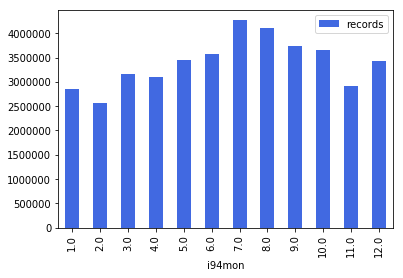

In [15]:
# Visualise monthly count stats
df_i94_agg_yr_mon.toPandas()\
    .plot.bar(x='i94mon', y='records', color='royalblue')

Mini observation: highest number of records during July 2016 (summer period) and lowest during Feb 2016.

#### i94: Data Dictionary of the raw i94 immigration monthly dataset

Fields and descriptions of the monthly i94 dataset, based on EDA analysis conducted from all the `EDA_*.ipynb` Notebook analysis and research conducted so far. This Dictionary might contain mistakes, mis-interpretations, mis-assumptions, and flaws. This is a starting point dictionary nevertheless, which we can gradually improve as we conduct further EDA and research.

Note that the global unique ID (GUID) is a combination of `i94yr`, `i94mon`, and `cicid`. This is validated by EDA `EDA_003_local_analyse_par_i94_v3.ipynb`.

Note also that we will generate those "lookup CSV" files at a later phase in the Notebook. These Lookup CSV will be parsed from data source 2 (`raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS`)

Fields in the i94 dataset:

* cicid : CICID is an unique ID for each US arrival-departure record which the visitor has filled in an i94 form. All arrival-departure CICID is unique. CICID is reset to 1 at the 1st of each arrival month.
* i94yr : 4 digit year (of the arrival date into the US)
* i94mon : Numeric month (of the arrival date into the US)
* i94cit : code. Visitor's country of citizenship. (i.e. as per passport). (see `raw_input_data/i94_lookup_csv/lookup_i94cntyl.csv`)
* i94res : code. Visitor's country of residence. (i.e. country travelling into the US from). (see `raw_input_data/i94_lookup_csv/lookup_i94cntyl.csv`)
* i94port: (3-letter code) port of entry into the US. (see `raw_input_data/i94_lookup_csv/lookup_i94port.csv`)
* arrdate: is date of arrrival (into the US). Currently in SAS Datetime format. We need to convert it to Python timestamp format.
* i94mode: mode of travelling into the US (sea, land, air, or not reported). Not appear to correlate to i94port (based on analysis). (see `raw_input_data/i94_lookup_csv/lookup_i94mode.csv`)
* i94addr: Visitor's residence (or accomodation) in the US, represented in 1-2 character codes. (not sure schema of code however). (see `raw_input_data/i94_lookup_csv/lookup_i94addr.csv`)
* depdate: is date of departure (out of the US). Currently in SAS Datetime format. We need to convert it to Python timestamp format.
* i94bir : Age of Respondent in Years.
* i94visa : (see `raw_input_data/i94_lookup_csv/lookup_i94visa.csv`)
* count : appears to be always 1. A classic approach to enable aggregate by summing to get the same effect as counting.
* dtadfile : Character Date Field - Date added to I-94 Files - CIC does not use
* visapost : Department of State where where Visa was issued - CIC does not use
* occup : Occupation that will be performed in U.S. - CIC does not use
* entdepa : Arrival Flag - admitted or paroled into the U.S. - CIC does not use
* entdepd : Departure Flag - Departed, lost I-94 or is deceased - CIC does not use
* entdepu : Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use
* matflag : Match flag - Match of arrival and departure records
* biryear : birth year of the immigrant on the i94 form.
* dtaddto : Character Date Field - Date to which admitted to U.S. (allowed to stay until) - CIC does not use.
* gender : Non-immigrant sex
* insnum : INS number. (Is this Insurance Number?)
* airline : Airline used to arrive in U.S.
* admnum : Every I-94 record has an eleven-digit admission number. This number may be needed at the Department of Motor Vehicles and for employment purposes, but it is not a number that needs to be memorized. In fact, a new I-94 number will be given each time the student or scholar re-enters the United States.
* fltno : Flight number of Airline used to arrive in U.S.
* visatype : is the type of visa which one owns (see `raw_input_data/i94_lookup_csv/lookup_i94visa.csv`)

References:

* https://internationaloffice.berkeley.edu/immigration/i94
* https://knowledge.udacity.com/questions/185453
* https://knowledge.udacity.com/questions/548968
* https://knowledge.udacity.com/questions/504012

In [16]:
def simple_groupby(spark, df, colname: str, ordered: bool = True):
    """ Given a Spark Session, Spark DataFrame and a group-by field, 
        do a simple count / groupby (one field only)
        Return a Spark DataFrame
    """
    df.createOrReplaceTempView("_tmp_df")
    sql_str = f"""\
        select {colname}, count(*) as records
        from _tmp_df
        group by 1
    """
    df2 = spark.sql(sql_str)
    if ordered:
        df2=df2.orderBy(colname)       
    return df2

#### cicid

CIC-ID. Unique ID of each visit. It is unique per Arrival year (`i94yr`) and month (`i94mon`).

Hypothesis and observations following analysis:

* Hypothesis (Validated): is that cicid is unique per arrival year-month.
* Hypothesis (Validated): total records per cicid could be between 1 and 12 (for the 12 months in 2016).
* Hypothesis (Both invalidated but it's ok): the total monthly count for each month, must be equal to the max cicid value for the month. And the min CICID is 1 for each month.

In [17]:
df_cicid_agg_1 = simple_groupby(spark, df_i94, 'cicid')
df_cicid_agg_1.show(10)

# Unfortunately the tail() method is not available until PySPark version 3.
# so have to use the less efficient descending sort! (to see largest values)
# df_cicid_agg_1.tail(10)
# df_cicid_agg_1.sort(F.col('cicid').desc()).show(10)

+-----+-------+
|cicid|records|
+-----+-------+
|  1.0|      1|
|  2.0|      4|
|  3.0|      3|
|  4.0|      3|
|  5.0|      5|
|  6.0|      6|
|  7.0|      7|
|  8.0|      5|
|  9.0|      4|
| 10.0|      2|
+-----+-------+
only showing top 10 rows



In [18]:
# My hypothesis is that cicid is unique per arrival year-month.
# if my hypothesis is correct then the following query should requrn 0 rows
# Result indicated: hypothesis is validated
spark.sql("""\
select
    cicid,
    i94yr,
    i94mon,
    count(*) as records
from df_i94
group by 1, 2, 3
having records > 1
""").show()

+-----+-----+------+-------+
|cicid|i94yr|i94mon|records|
+-----+-----+------+-------+
+-----+-----+------+-------+



In [19]:
# My hypothesis is that cicid is unique per arrival year-month.
# if my hypothesis is correct then the following query should requrn some rows
# Result indicated: hypothesis is validated
spark.sql("""\
select
    cicid,
    count(*) as records
from df_i94
group by 1
having records > 1
""").show()

+---------+-------+
|    cicid|records|
+---------+-------+
|5680982.0|      7|
|5681018.0|      6|
|5681279.0|      6|
|5681289.0|      8|
|5681452.0|      5|
|5681523.0|      8|
|5681771.0|      6|
|5682204.0|      3|
|5682909.0|      7|
|5683017.0|      7|
|5683674.0|      6|
|5684532.0|      5|
|5684559.0|      3|
|5684829.0|      5|
|5685062.0|      6|
|5685608.0|      5|
|5686057.0|      7|
|5686102.0|      7|
|5686163.0|      7|
|5686168.0|      4|
+---------+-------+
only showing top 20 rows



In [20]:
# what's the min and max number of records per CICID (during 2016?)
# My hypothesis is that CICID resets to 1 at the beginning of every month.
# i.e. for a period of 12 months, I would expect the min is 1, and the max is 12.
# Result suggests: hypothesis validated.
spark.sql("""\
select
    min(records) as min_records,
    max(records) as max_records
from (
    select
        cicid,
        count(*) as records
    from df_i94
    group by 1
)
""").show()

+-----------+-----------+
|min_records|max_records|
+-----------+-----------+
|          1|         12|
+-----------+-----------+



In [21]:
# What is the min and max cicid for each month?
# if cicid is indeed reset at 1 at beginning of each month, and incrementally increasing/
# then the total monthly cound for each month, must be equal to the max cicid (the hypothesis).
# also, the min CICID is 1 for each month.
# Result suggests: hypothesis invalidated
# (But this is ok, as long as CICID is unique per month, which we have validated, we are ok.)
spark.sql(f"""
select
    i94yr,
    i94mon,
    min(cicid) as min_cic_id,
    max(cicid) as max_cic_id,
    count(*) as records
from df_i94
group by 1, 2
order by 1, 2
""").show()

+------+------+----------+----------+-------+
| i94yr|i94mon|min_cic_id|max_cic_id|records|
+------+------+----------+----------+-------+
|2016.0|   1.0|       7.0| 6148395.0|2847924|
|2016.0|   2.0|       2.0| 5507053.0|2570543|
|2016.0|   3.0|       2.0| 6757651.0|3157072|
|2016.0|   4.0|       6.0| 6102785.0|3096313|
|2016.0|   5.0|       2.0| 6484857.0|3444249|
|2016.0|   6.0|       4.0| 6432838.0|3574989|
|2016.0|   7.0|       1.0| 7667577.0|4265031|
|2016.0|   8.0|      22.0| 7231273.0|4103570|
|2016.0|   9.0|     155.0| 6733429.0|3733786|
|2016.0|  10.0|       5.0| 6403017.0|3649136|
|2016.0|  11.0|       8.0| 5812458.0|2914926|
|2016.0|  12.0|       6.0| 7318723.0|3432990|
+------+------+----------+----------+-------+



#### i94yr

i94yr - 4 digit year (of the arrival date into the US)

In [22]:
df_i94yr_agg_1 = simple_groupby(spark, df_i94, 'i94yr')
df_i94yr_agg_1.show()

+------+--------+
| i94yr| records|
+------+--------+
|2016.0|40790529|
+------+--------+



#### i94mon

i94mon - Numeric month (of the arrival date into the US)

In [23]:
df_i94mon_agg_1 = simple_groupby(spark, df_i94, 'i94mon')
df_i94mon_agg_1.show()

+------+-------+
|i94mon|records|
+------+-------+
|   1.0|2847924|
|   2.0|2570543|
|   3.0|3157072|
|   4.0|3096313|
|   5.0|3444249|
|   6.0|3574989|
|   7.0|4265031|
|   8.0|4103570|
|   9.0|3733786|
|  10.0|3649136|
|  11.0|2914926|
|  12.0|3432990|
+------+-------+



#### i94cit and i94res

This format shows all the valid and invalid (country) codes for processing

* `i94cit` - Visitor's country of citizenship. (i.e. as per passport).
* `i94res` - Visitor's country of residence. (i.e. country travelling into the US from).

Idea: parse lookup table (PROC FORMAT) from `I94_SAS_Labels_Descriptions.SAS` into a structured dataset (e.g. tabular dataframe / csv) for downstream processing.

Rationale for idea: we may potentially map `i94cit` and `i94res` (numeric code) to some meaningful string values (country).

Observation:

* Key: integer code (1-3 digits)
* Value: country name, or state name.

In [24]:
df_i94cit_agg_1 = simple_groupby(spark, df_i94, 'i94cit')
df_i94cit_agg_1.show()

+------+-------+
|i94cit|records|
+------+-------+
|  null|  28575|
|   0.0|   1288|
| 101.0|  11424|
| 102.0|   1287|
| 103.0| 203883|
| 104.0| 270440|
| 105.0|  30101|
| 106.0|      5|
| 107.0| 190060|
| 108.0| 328086|
| 109.0|  23583|
| 110.0| 154249|
| 111.0|1679312|
| 112.0|  10537|
| 113.0|  82025|
| 114.0|  85107|
| 115.0|  58268|
| 116.0| 476312|
| 117.0|1116790|
| 118.0|  20870|
+------+-------+
only showing top 20 rows



In [25]:
df_i94res_agg_1 = simple_groupby(spark, df_i94, 'i94res')
df_i94res_agg_1.show()

+------+-------+
|i94res|records|
+------+-------+
| 101.0|  12317|
| 102.0|   1589|
| 103.0| 199332|
| 104.0| 276722|
| 105.0|  28080|
| 107.0| 180847|
| 108.0| 327074|
| 109.0|  22441|
| 110.0| 150704|
| 111.0|1641152|
| 112.0|2046288|
| 113.0|  74444|
| 114.0|  78625|
| 115.0|  57856|
| 116.0| 443005|
| 117.0| 988860|
| 118.0|  19420|
| 119.0|   2082|
| 120.0|  27660|
| 121.0|  19360|
+------+-------+
only showing top 20 rows



#### i94port

i94port - (3-letter code) port of entry into the US. This format shows all the valid and invalid codes for processing

Idea: parse lookup table (PROC FORMAT) from `I94_SAS_Labels_Descriptions.SAS` into a structured dataset (e.g. tabular dataframe / csv) for downstream processing.

Rationale for idea: we may potentially map `i94port` (3 character code) to some meaningful string values.

In [26]:
df_i94port_agg_1 = simple_groupby(spark, df_i94, 'i94port')
df_i94port_agg_1.show()

+-------+-------+
|i94port|records|
+-------+-------+
|    48Y|      2|
|    5KE|     58|
|    5T6|    161|
|    74S|      1|
|    ABE|      2|
|    ABG|    527|
|    ABQ|     61|
|    ABS|    264|
|    ACY|      5|
|    ADS|    388|
|    ADT|    124|
|    ADW|    505|
|    AFW|     19|
|    AGA|1337940|
|    AGM|      2|
|    AGN|    163|
|    AGU|     12|
|    ALB|     49|
|    ALC|   3976|
|    ANA|      2|
+-------+-------+
only showing top 20 rows



#### arrdate and depdate

Both are in SAS Datetime format. We need to convert it to Python timestamp format.

* `arrdate` - Date of arrrival (into the US).
* `depdate` - Date of arrrival (into the US). 

Reference: `EDA_005_local_analyse_par_i94_v4.ipynb`

In [27]:
df_arrdate_agg_1 = simple_groupby(spark, df_i94, 'arrdate')
df_arrdate_agg_1.show()

+-------+-------+
|arrdate|records|
+-------+-------+
|20454.0|  83984|
|20455.0|  75646|
|20456.0|  79959|
|20457.0|  89325|
|20458.0|  85650|
|20459.0|  84420|
|20460.0|  93107|
|20461.0|  93818|
|20462.0| 101576|
|20463.0| 106167|
|20464.0|  99145|
|20465.0|  84688|
|20466.0|  85486|
|20467.0|  92151|
|20468.0|  95030|
|20469.0| 107911|
|20470.0| 110195|
|20471.0| 108063|
|20472.0|  85322|
|20473.0|  90017|
+-------+-------+
only showing top 20 rows



In [28]:
# Got some negative numeric values and null
df_depdate_agg_1 = simple_groupby(spark, df_i94, 'depdate')
df_depdate_agg_1.show(40)

+--------+-------+
| depdate|records|
+--------+-------+
|    null|3308012|
|-14388.0|      1|
|-14375.0|      1|
|-14359.0|      1|
|-14342.0|      4|
|-14334.0|      3|
|-14328.0|      1|
|-14321.0|      1|
|-14312.0|      3|
|-14307.0|     28|
|-14283.0|      1|
|-14021.0|      1|
|-14011.0|      1|
|-13977.0|      1|
|-13888.0|      1|
|-12285.0|      1|
|-11972.0|      1|
|-11950.0|      1|
| -6717.0|      1|
|   598.0|      1|
|   669.0|      1|
|   962.0|      1|
|  4260.0|      1|
|  4264.0|      1|
|  4331.0|      1|
|  7924.0|      1|
| 14979.0|      1|
| 14991.0|      1|
| 15065.0|      1|
| 15176.0|      1|
| 15279.0|      1|
| 16809.0|      1|
| 17032.0|      1|
| 17076.0|      1|
| 17119.0|      1|
| 17122.0|      1|
| 17143.0|      1|
| 17335.0|      1|
| 18289.0|      1|
| 18318.0|      1|
+--------+-------+
only showing top 40 rows



In [29]:
def convert_datetime(sas_date):
    """ Give a SAS Date, return the equivalent in Python datetime 
    Ref: https://knowledge.udacity.com/questions/66798
    """
    try:
        if (sas_date == 'null'):
            sas_date = 0
        start_cutoff = datetime(1960, 1, 1)
        return start_cutoff + timedelta(days=int(sas_date))
    except:
        return None


# Mini Unit Tests
assert convert_datetime(20484) ==  datetime(2016, 1, 31)
assert convert_datetime(20484).strftime('%Y-%m-%d') ==  '2016-01-31'

In [30]:
# Create two new columns in Python datetime: arrdate_pydt (from arrdate) and depdate_pydt (from depdate)
udf_datetime_from_sas = F.udf(lambda x: convert_datetime(x), T.DateType())
df_i94 = df_i94.withColumn('arrdate_pydt', udf_datetime_from_sas(df_i94.arrdate))
df_i94 = df_i94.withColumn('depdate_pydt', udf_datetime_from_sas(df_i94.depdate))

In [31]:
# Let's take a peek
# In addition, let's use this as an opportunity to test a hypothesis
# Hypothesis (Validated): the same CICID of different monthly i94 datasets are mutually exclusive.
# Observation: it appears that the monthly datasets are mutually exclusive to each other.
# This means that the same CICID (say, 5748517) does not neccessary represent the same immigrant in Jan dataset, 
# vs the Feb dataset (and so on). i.e it appears that CICID is just a way for the dataset to capture immigration data.
df_i94.createOrReplaceTempView('df_i94')
spark.sql("""
select
    cicid,
    i94yr,
    i94mon,
    i94cit,
    i94res,
    i94port,
    arrdate,
    arrdate_pydt,
    depdate,
    depdate_pydt
from df_i94
where cicid = 5748517
order by 1,2,3
limit 1000
""").show()

+---------+------+------+------+------+-------+-------+------------+-------+------------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|arrdate_pydt|depdate|depdate_pydt|
+---------+------+------+------+------+-------+-------+------------+-------+------------+
|5748517.0|2016.0|   1.0| 135.0| 135.0|    LOS|20484.0|  2016-01-31|   null|        null|
|5748517.0|2016.0|   3.0| 135.0| 135.0|    NYC|20541.0|  2016-03-28|20545.0|  2016-04-01|
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|  2016-04-30|20582.0|  2016-05-08|
|5748517.0|2016.0|   6.0| 252.0| 209.0|    AGA|20631.0|  2016-06-26|   null|        null|
|5748517.0|2016.0|   7.0| 251.0| 251.0|    NYC|20659.0|  2016-07-24|20665.0|  2016-07-30|
|5748517.0|2016.0|   8.0| 117.0| 117.0|    WAS|20691.0|  2016-08-25|20699.0|  2016-09-02|
|5748517.0|2016.0|   9.0| 254.0| 276.0|    AGA|20723.0|  2016-09-26|20728.0|  2016-10-01|
|5748517.0|2016.0|  10.0| 111.0| 111.0|    NYC|20755.0|  2016-10-28|20762.0|  2016-11-04|
|5748517.0

In [32]:
# Hypothesis (Validated): the year-month of the i94 form (`i94yr` and `i94mon`) 
# matches exactly as the arrivate date into the US (`year(arrdate_pydt)` and `month(arrdate_pydt)`)
# Observation: It also appears that the i94yr and i94mon corresponds to the arrivate date (into the US)
# looking at an example. (we can validate this by comparing year-month of the datast (`i94yr` and `i94mon`), vs the year-month of the arrival date (`arrdate_pydt`).
spark.sql("""
select
    i94yr,
    i94mon,
    year(arrdate_pydt) as arr_year,
    month(arrdate_pydt) as arr_mon,
    count(*)
from df_i94
group by 1,2,3,4
order by 1,2,3,4
""").show()

+------+------+--------+-------+--------+
| i94yr|i94mon|arr_year|arr_mon|count(1)|
+------+------+--------+-------+--------+
|2016.0|   1.0|    2016|      1| 2847924|
|2016.0|   2.0|    2016|      2| 2570543|
|2016.0|   3.0|    2016|      3| 3157072|
|2016.0|   4.0|    2016|      4| 3096313|
|2016.0|   5.0|    2016|      5| 3444249|
|2016.0|   6.0|    2016|      6| 3574989|
|2016.0|   7.0|    2016|      7| 4265031|
|2016.0|   8.0|    2016|      8| 4103570|
|2016.0|   9.0|    2016|      9| 3733786|
|2016.0|  10.0|    2016|     10| 3649136|
|2016.0|  11.0|    2016|     11| 2914926|
|2016.0|  12.0|    2016|     12| 3432990|
+------+------+--------+-------+--------+



Mini summary on dates:

Hypothesis 1 (Validated): the same CICID of different monthly i94 datasets are mutually exclusive.

* it appears that the monthly datasets are mutually exclusive to each other.
* This means that the same CICID (say, 5748517) does not neccessary represent the same immigrant in Jan dataset, vs the Feb dataset (and so on). i.e it appears that CICID is just a way for the dataset to capture immigration data.

Hypothesis 2 (Validated): the year-month of the i94 form (`i94yr` and `i94mon`) matches exactly as the arrivate date into the US (`year(arrdate_pydt)` and `month(arrdate_pydt)`)

#### i94mode

i94mode - There are missing values as well as not reported.

Idea: parse lookup table (PROC FORMAT) from `I94_SAS_Labels_Descriptions.SAS` into a structured dataset (e.g. tabular dataframe / csv) for downstream processing.

Rationale for idea: we may potentially map `i94mode` (numeric code) to some meaningful string values (mode of transport)

* Key: integer
* Value: mode of transport:

```
    1 = 'Air'
    2 = 'Sea'
    3 = 'Land'
    9 = 'Not reported'
```

In [33]:
df_i94mode_agg_1 = simple_groupby(spark, df_i94, 'i94mode')
df_i94mode_agg_1.show()

+-------+--------+
|i94mode| records|
+-------+--------+
|   null|   73949|
|    0.0|       4|
|    1.0|39166088|
|    2.0|  387184|
|    3.0| 1095001|
|    9.0|   68303|
+-------+--------+



#### i94addr

i94addr - There are lots of invalid codes in this variable and the list below shows what we have found to be valid, everything else goes into 'other'

Idea: parse lookup table (PROC FORMAT) from `I94_SAS_Labels_Descriptions.SAS` into a structured dataset (e.g. tabular dataframe / csv) for downstream processing.

Rationale for idea: we may potentially map `i94addr` (1-2 character code) to some meaningful string values (name of the US State or oversea territories)


In [34]:
df_i94addr_agg_1 = simple_groupby(spark, df_i94, 'i94addr')
df_i94addr_agg_1.show()

+-------+-------+
|i94addr|records|
+-------+-------+
|   null|2027926|
|     **|      4|
|     ..|    254|
|     .7|      1|
|     .9|      3|
|     .A|      5|
|     .C|    206|
|     .D|     14|
|     .F|      4|
|     .H|      7|
|     .I|     27|
|     .K|      2|
|     .L|      4|
|     .M|     11|
|     .N|     36|
|     .O|      3|
|     .S|      7|
|     .T|     56|
|     .V|      5|
|     .W|      1|
+-------+-------+
only showing top 20 rows



#### i94bir

I94BIR - Age of Respondent in Years

Observation: 

* there are some invalue values (negative 1/2/3 years old?).
* abnormally large age? 1812 years old?
* null should be ok as these are just unprovided data points?
* are zero years old actually zero, or are some of these null? (some people like to use 0 to denote null)

```
+------+-------+
|i94bir|records|
+------+-------+
|  null|   9517|
|  -3.0|      1|
|  -2.0|      2|
|  -1.0|      7|
...
|1812.0|      2|
+------+-------+
```

(Note: these abnormalities likely relates to the `biryear` analysis)

In [35]:
df_i94bir_agg_1 = simple_groupby(spark, df_i94, 'i94bir')
df_i94bir_agg_1.show()

+------+-------+
|i94bir|records|
+------+-------+
|  null|   9517|
|  -3.0|      1|
|  -2.0|      2|
|  -1.0|      7|
|   0.0|  44698|
|   1.0| 173201|
|   2.0| 178813|
|   3.0| 168773|
|   4.0| 195652|
|   5.0| 210899|
|   6.0| 227145|
|   7.0| 235070|
|   8.0| 252727|
|   9.0| 268906|
|  10.0| 276404|
|  11.0| 282934|
|  12.0| 304090|
|  13.0| 313089|
|  14.0| 331748|
|  15.0| 386115|
+------+-------+
only showing top 20 rows



In [36]:
df_i94bir_agg_1.sort(F.col("i94bir").desc()).show()

+------+-------+
|i94bir|records|
+------+-------+
|1812.0|      2|
| 116.0|      9|
| 115.0|      5|
| 114.0|      4|
| 113.0|      8|
| 112.0|     10|
| 111.0|     10|
| 110.0|     11|
| 109.0|     15|
| 108.0|     16|
| 107.0|     12|
| 106.0|     19|
| 105.0|    108|
| 104.0|     92|
| 103.0|     65|
| 102.0|     77|
| 101.0|     86|
| 100.0|    185|
|  99.0|    186|
|  98.0|    253|
+------+-------+
only showing top 20 rows



#### i94visa

I94VISA - Visa codes collapsed into three categories:

```
   1 -> "Business"
   2 -> "Pleasure"
   3 -> "Student"
```

In [37]:
df_i94visa_agg_1 = simple_groupby(spark, df_i94, 'i94visa')
df_i94visa_agg_1.show()

+-------+--------+
|i94visa| records|
+-------+--------+
|    1.0| 5575279|
|    2.0|33641979|
|    3.0| 1573271|
+-------+--------+



#### count

COUNT - Used for summary statistics.

Obervation: looks like this column is always `1`. This is a classic technique for easie of aggregation (so we summing this column is equivalent as counting rows).

In [38]:
df_count_agg_1 = simple_groupby(spark, df_i94, 'count')
df_count_agg_1.show()

+-----+--------+
|count| records|
+-----+--------+
|  1.0|40790529|
+-----+--------+



# dtadfile

DTADFILE - Character Date Field - Date added to I-94 Files - CIC does not use

Observation: looks like numbers are in date like format: yyyymmdd

In [39]:
df_dtadfile_agg_1 = simple_groupby(spark, df_i94, 'dtadfile')
df_dtadfile_agg_1.show()

+--------+-------+
|dtadfile|records|
+--------+-------+
|    null| 131050|
|20081124|      1|
|20120102|      1|
|20120418|      1|
|20120831|      1|
|20130312|      1|
|20130514|      1|
|20130811|      1|
|20140407|      1|
|20150107|      1|
|20150406|      1|
|20150530|      1|
|20150608|      1|
|20150619|      1|
|20150806|      1|
|20150810|      1|
|20150822|      1|
|20150824|      1|
|20150912|      1|
|20151015|      3|
+--------+-------+
only showing top 20 rows



#### visapost

VISAPOST - Department of State where where Visa was issued - CIC does not use

In [40]:
df_visapost_agg_1 = simple_groupby(spark, df_i94, 'visapost')
df_visapost_agg_1.show()

+--------+--------+
|visapost| records|
+--------+--------+
|    null|24032175|
|     999|    8823|
|     ABD|   45618|
|     ABG|     598|
|     ABJ|    6025|
|     ABS|     121|
|     ABU|   43207|
|     ACC|   16622|
|     ACK|   16054|
|     ADA|      31|
|     ADD|   16650|
|     ADL|       6|
|     ADN|       3|
|     ADT|       3|
|     AGA|    1166|
|     AKD|    1099|
|     ALB|      19|
|     ALC|      10|
|     ALG|    7444|
|     ALP|       4|
+--------+--------+
only showing top 20 rows



#### occup

OCCUP - Occupation that will be performed in U.S. - CIC does not use

In [41]:
df_occup_agg_1 = simple_groupby(spark, df_i94, 'occup')
df_occup_agg_1.show()

+-----+--------+
|occup| records|
+-----+--------+
| null|40597574|
|  010|       1|
|  035|       1|
|  037|       1|
|  039|       2|
|  049|       6|
|  093|       1|
|  100|       1|
|  101|       1|
|  111|       1|
|  120|       1|
|  130|       1|
|  200|       2|
|  300|       3|
|  430|       5|
|  800|       1|
|  850|       3|
|  855|     260|
|  992|      80|
|  995|       1|
+-----+--------+
only showing top 20 rows



#### entdepa

ENTDEPA - Arrival Flag - admitted or paroled into the U.S. - CIC does not use.

In [42]:
df_entdepa_agg_1 = simple_groupby(spark, df_i94, 'entdepa')
df_entdepa_agg_1.show()

+-------+--------+
|entdepa| records|
+-------+--------+
|   null|    2404|
|      A| 1441544|
|      B|    1957|
|      F|      26|
|      G|30937479|
|      H|  190602|
|      I|   52706|
|      J|     118|
|      K|  265447|
|      M|     251|
|      N|    3649|
|      O| 5692584|
|      P|  197710|
|      Q|     274|
|      R|     316|
|      T|  896198|
|      U|   38896|
|      Z| 1068368|
+-------+--------+



#### entdepd

ENTDEPA - Departure Flag - Departed, lost I-94 or is deceased - CIC does not use

In [43]:
df_entdepd_agg_1 = simple_groupby(spark, df_i94, 'entdepd')
df_entdepd_agg_1.show()

+-------+--------+
|entdepd| records|
+-------+--------+
|   null| 3287909|
|      D| 1226934|
|      G|   15089|
|      I| 1395706|
|      J|   21315|
|      K| 1053478|
|      L|     304|
|      M|     223|
|      N|  654917|
|      O|31560000|
|      Q|  896570|
|      R|  551183|
|      T|     656|
|      V|   39257|
|      W|   86873|
|      Y|       2|
|      Z|     113|
+-------+--------+



#### entdepu

ENTDEPU - Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use

In [44]:
# WARNING: can take very long?
df_entdepu_agg_1 = simple_groupby(spark, df_i94, 'entdepu')
df_entdepu_agg_1.show()

+-------+--------+
|entdepu| records|
+-------+--------+
|   null|40777323|
|      P|       2|
|      U|   13156|
|      Y|      48|
+-------+--------+



#### matflag

MATFLAG - Match flag - Match of arrival and departure records

In [45]:
df_matflag_agg_1 = simple_groupby(spark, df_i94, 'matflag')
df_matflag_agg_1.show()

+-------+--------+
|matflag| records|
+-------+--------+
|   null| 3219581|
|      M|37570948|
+-------+--------+



#### biryear

BIRYEAR - 4 digit year of birth. 

Observation:

* 2 invalid bird year: 204?

```
+-------+-------+
|biryear|records|
+-------+-------+
|  204.0|      2|
```

* Birthday in the future? (given arrival dataset is 2016):

```
+-------+-------+
|biryear|records|
+-------+-------+
| 2019.0|      1|
| 2018.0|      2|
| 2017.0|      7|
```

(Note: these records are likely related to what we saw in the `i94bir` (age of visitor) analysis, where we saw some abnormally large value in age, and negative age.)

In [46]:
df_biryear_agg_1 = simple_groupby(spark, df_i94, 'biryear')
df_biryear_agg_1.show(10)
df_biryear_agg_1.sort(F.col("biryear").desc()).show()

+-------+-------+
|biryear|records|
+-------+-------+
|   null|   9517|
|  204.0|      2|
| 1900.0|      9|
| 1901.0|      5|
| 1902.0|      4|
| 1903.0|      8|
| 1904.0|     10|
| 1905.0|     10|
| 1906.0|     11|
| 1907.0|     15|
+-------+-------+
only showing top 10 rows

+-------+-------+
|biryear|records|
+-------+-------+
| 2019.0|      1|
| 2018.0|      2|
| 2017.0|      7|
| 2016.0|  44698|
| 2015.0| 173201|
| 2014.0| 178813|
| 2013.0| 168773|
| 2012.0| 195652|
| 2011.0| 210899|
| 2010.0| 227145|
| 2009.0| 235070|
| 2008.0| 252727|
| 2007.0| 268906|
| 2006.0| 276404|
| 2005.0| 282934|
| 2004.0| 304090|
| 2003.0| 313089|
| 2002.0| 331748|
| 2001.0| 386115|
| 2000.0| 431350|
+-------+-------+
only showing top 20 rows



#### dtaddto

DTADDTO - Character Date Field - Date to which admitted to U.S. (allowed to stay until) - CIC does not use

Observations:

* in general numeric value appear to be in US dateformat: mmddyyyy
* null values probably meant not applicable?
* Contains invalid values

```
+--------+-------+
| dtaddto|records|
+--------+-------+
|-00-0000|      3|
|/   183D|      1|
|   /184D|      1|
```

In [47]:
df_dtaddto_agg_1 = simple_groupby(spark, df_i94, 'dtaddto')
df_dtaddto_agg_1.show(10)

+--------+-------+
| dtaddto|records|
+--------+-------+
|    null| 101551|
|-00-0000|      3|
|/   183D|      1|
|   /184D|      1|
|00000000|  40209|
|01011970|      2|
|01012016|     16|
|01012017| 127109|
|01012018|   2977|
|01012019|      3|
+--------+-------+
only showing top 10 rows



#### gender

GENDER - Non-immigrant sex

Question: what are "U" and "X"?

```
+------+--------+
|gender| Meaning|
+------+--------+
|     F|Female  |
|     M|Male    |
|     U|???     |
|     X|???     |
+------+--------+
```

In [48]:
df_gender_agg_1 = simple_groupby(spark, df_i94, 'gender')
df_gender_agg_1.show()

+------+--------+
|gender| records|
+------+--------+
|  null| 4079983|
|     F|18176125|
|     M|18504505|
|     U|   18906|
|     X|   11010|
+------+--------+



#### insnum

INSNUM - INS number (is this Insurance Number?)

Observations:

* appear numeric in general with zero padded on left.
* abnormal values:

```
+------+--------+
|insnum| records|
+------+--------+
|     '|       5|
| '2868|       1|
| '3884|       1|
| .3434|       1|
| .3890|       1|
| /3685|       1|
|     0|       6|
```

In [49]:
df_insnum_agg_1 = simple_groupby(spark, df_i94, 'insnum')
df_insnum_agg_1.show()

+------+--------+
|insnum| records|
+------+--------+
|  null|35678095|
|     '|       5|
| '2868|       1|
| '3884|       1|
| .3434|       1|
| .3890|       1|
| /3685|       1|
|     0|       6|
|000078|    2784|
| 00037|     132|
|  0004|      53|
| 00041|      35|
| 00058|      11|
|  0007|       4|
| 00076|      11|
| 00081|     140|
| 00083|       2|
|000861|       1|
|  0009|       7|
| 00091|    2742|
+------+--------+
only showing top 20 rows



#### airline

AIRLINE - Airline used to arrive in U.S.

In [50]:
df_airline_agg_1 = simple_groupby(spark, df_i94, 'airline')
df_airline_agg_1.show()

+-------+-------+
|airline|records|
+-------+-------+
|   null|1308066|
|    *FF|    952|
|    *GA| 102156|
|    *UU|    342|
|    001|      6|
|    006|     26|
|    009|    101|
|    00F|      1|
|    00I|      2|
|    00K|      1|
|    00X|      8|
|    012|      1|
|    017|      8|
|    018|     26|
|    01B|      1|
|    020|      1|
|    026|    152|
|    027|      2|
|    029|     31|
|    02Z|      2|
+-------+-------+
only showing top 20 rows



#### admnum

ADMNUM - Admission Number

Note that the fact we have 498 records with admnum ID 0, shows that this is not currently a reliable globally unique ID.

In [51]:
df_admnum_agg_1 = simple_groupby(spark, df_i94, 'admnum')
df_admnum_agg_1.show()

+---------+-------+
|   admnum|records|
+---------+-------+
|      0.0|    498|
|     27.0|      1|
|     33.0|      1|
|  79733.0|      1|
| 197185.0|      1|
| 452033.0|      1|
| 971885.0|      1|
|1004233.0|      1|
|1078085.0|      1|
|1218224.0|      1|
|1219024.0|      1|
|1219124.0|      1|
|1219224.0|      1|
|1219324.0|      1|
|1219424.0|      1|
|1222424.0|      1|
|1226124.0|      1|
|1226224.0|      1|
|1233085.0|      1|
|1236624.0|      1|
+---------+-------+
only showing top 20 rows



In [52]:
spark.sql("""
select 
    min(admnum) as min_admnum,
    max(admnum) as max_admnum
from df_i94
""").show()

+----------+--------------+
|min_admnum|    max_admnum|
+----------+--------------+
|       0.0|9.999999813E10|
+----------+--------------+



#### fltno

FLTNO - Flight number of Airline used to arrive in U.S.

In [53]:
df_fltno_agg_1 = simple_groupby(spark, df_i94, 'fltno')
df_fltno_agg_1.show()

+-----+-------+
|fltno|records|
+-----+-------+
| null| 333922|
|    -|      1|
|-PF10|      3|
|-XCHI|      2|
|-XCNP|      6|
|-XCPF|     41|
|0 111|      2|
|0 178|      1|
|0 188|      2|
|0 294|      1|
|0 301|      2|
|0 314|      1|
|0 336|      1|
|0 608|      1|
|0 612|      1|
|0 622|      1|
|0 874|      2|
|0 941|      1|
|   00|      2|
|00 20|      1|
+-----+-------+
only showing top 20 rows



#### visatype

VISATYPE - Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

In [54]:
df_visatype_agg_1 = simple_groupby(spark, df_i94, 'visatype')
df_visatype_agg_1.show()

+--------+--------+
|visatype| records|
+--------+--------+
|      B1| 2282096|
|      B2|15188785|
|      CP|  272007|
|     CPL|     236|
|      E1|   48905|
|      E2|  259215|
|      F1| 1487432|
|      F2|   68866|
|     GMB|    2728|
|     GMT| 1265275|
|       I|   39054|
|      I1|    2825|
|      M1|   16306|
|      M2|     667|
|     SBP|      61|
|      WB| 2940456|
|      WT|16915615|
+--------+--------+



#### Write groupby stats into CSV files

We've done a lot of group-by stats above. Let's cache them into CSV files (showing top 1000 rows). So that our analytical teams may quickly get a feel of the distinct values (and associated counts).

In [55]:
RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV = config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV')
print(f"RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV: {RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV}")

def write_groupby_stats_csv(
        df_spark,
        groupby_field_name,
        out_filename,
        n_rows=1000,
        out_dir=RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV
    ):
    """ given one spark dataframe (in a specific schema) save into a CSV file """
    
    print(f'writing: {out_filename}')
    pd.DataFrame(df_spark.take(n_rows), columns=[groupby_field_name, 'count'])\
        .to_csv(f"{out_dir}/{out_filename}", index=False)

    

def bulk_write_groupby_stats_csv(
        n_rows=1000,
        out_dir=RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV):
    """ bulk run write_groupby_stats_csv """
    for e in [
        (df_cicid_agg_1, 'cicid', "df_cicid_agg_1.csv"),
        (df_i94yr_agg_1, 'i94yr', "df_i94yr_agg_1.csv"),
        (df_i94mon_agg_1, 'i94mon', "df_i94mon_agg_1.csv"),
        (df_i94cit_agg_1, 'i94cit', "df_i94cit_agg_1.csv"),
        (df_i94res_agg_1, 'i94res', "df_i94res_agg_1.csv"),        
        (df_i94port_agg_1, 'i94port', "df_i94port_agg_1.csv"),
        (df_arrdate_agg_1, 'arrdate', "df_arrdate_agg_1.csv"),
        (df_i94mode_agg_1, 'i94mode', "df_i94mode_agg_1.csv"),
        (df_i94addr_agg_1, 'i94addr', "df_i94addr_agg_1.csv"),
        (df_depdate_agg_1, 'depdate', "df_depdate_agg_1.csv"),
        (df_i94bir_agg_1, 'i94bir', "df_i94bir_agg_1.csv"),
        (df_i94visa_agg_1, 'i94visa', "df_i94visa_agg_1.csv"),
        (df_count_agg_1, 'count', "df_count_agg_1.csv"),
        (df_dtadfile_agg_1, 'dtadfile', "df_dtadfile_agg_1.csv"),
        (df_visapost_agg_1, 'visapost', "df_visapost_agg_1.csv"),
        (df_occup_agg_1, 'occup', "df_occup_agg_1.csv"),
        (df_entdepa_agg_1, 'entdepa', "df_entdepa_agg_1.csv"),
        (df_entdepd_agg_1, 'entdepd', "df_entdepd_agg_1.csv"),
        (df_entdepu_agg_1, 'entdepu', "df_entdepu_agg_1.csv"),
        (df_matflag_agg_1, 'matflag', "df_matflag_agg_1.csv"),        
        (df_biryear_agg_1, 'biryear', "df_biryear_agg_1.csv"),   
        (df_dtaddto_agg_1, 'dtaddto', "df_dtaddto_agg_1.csv"),   
        (df_gender_agg_1, 'gender', "df_gender_agg_1.csv"),   
        (df_insnum_agg_1, 'insnum', "df_insnum_agg_1.csv"),   
        (df_airline_agg_1, 'airline', "df_airline_agg_1.csv"),   
        (df_admnum_agg_1, 'admnum', "df_admnum_agg_1.csv"),   
        (df_fltno_agg_1, 'fltno', "df_fltno_agg_1.csv"),
        (df_visatype_agg_1, 'visatype', "df_visatype_agg_1.csv")
    ]:
        # write Spark DataFrame to a CSV file
        write_groupby_stats_csv(
            df_spark=e[0],
            groupby_field_name=e[1],
            out_filename=e[2],
            n_rows=n_rows,
            out_dir=out_dir,
        )
        

RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV: raw_input_data/i94_sample_groupby_stats_csv/


In [56]:
bulk_write_groupby_stats_csv(n_rows=1000, out_dir=RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV)

writing: df_cicid_agg_1.csv
writing: df_i94yr_agg_1.csv
writing: df_i94mon_agg_1.csv
writing: df_i94cit_agg_1.csv
writing: df_i94res_agg_1.csv
writing: df_i94port_agg_1.csv
writing: df_arrdate_agg_1.csv
writing: df_i94mode_agg_1.csv
writing: df_i94addr_agg_1.csv
writing: df_depdate_agg_1.csv
writing: df_i94bir_agg_1.csv
writing: df_i94visa_agg_1.csv
writing: df_count_agg_1.csv
writing: df_dtadfile_agg_1.csv
writing: df_visapost_agg_1.csv
writing: df_occup_agg_1.csv
writing: df_entdepa_agg_1.csv
writing: df_entdepd_agg_1.csv
writing: df_entdepu_agg_1.csv
writing: df_matflag_agg_1.csv
writing: df_biryear_agg_1.csv
writing: df_dtaddto_agg_1.csv
writing: df_gender_agg_1.csv
writing: df_insnum_agg_1.csv
writing: df_airline_agg_1.csv
writing: df_admnum_agg_1.csv
writing: df_fltno_agg_1.csv
writing: df_visatype_agg_1.csv


### Assess Source 2: A SAS Program file that contains the lookup of codes to categorical string values

Source 2: A SAS Program file that contains the lookup of codes to categorical string values

* File format: `.SAS` Text File (containing SAS Code Syntax)
* Content: this is a semi-structured text file that contains lookup logic from (numeric or character) codes to categorical string values, for the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`.
* Remark: we will have an automated Python script to read in this text file, and auto derive CSV lookup tables (as descibed in bullet point 4 below).    
* Official source location (no documentations identified. Likely come from the same source as source (1) above.)
* Relative Path: `raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS`

Overall steps:

1. Manually have a read of `I94_SAS_Labels_Descriptions.SAS`, try and get an idea of the lookup logic between categorical code and string values. Can we programmatically extract those mapping?
2. Given the `I94_SAS_Labels_Descriptions.SAS` text file, programmatically create CSV lookup tables. Given the small dataset, we can do this with just Pandas (no Spark required).

* lookup_i94cntyl.csv
* lookup_i94port.csv
* lookup_i94mode.csv
* lookup_i94addr.csv
* lookup_i94visa.csv

3. Have a sanity check at these CSV files (e.g. ensure keys are unique)

We have done all of the above via a seperate notebook already: `EDA_004_local_extract_i94_lookup_from_sas.ipynb`, but we will include in here for completeness (with enhancement to make turning into a proper Python scripts in future easier).

In [58]:
# This utility aims to disect the semi-structured I94_SAS_Labels_Descriptions.SAS file
# And return the lookup logic into tabular Pandas DataFrames and/or CSV files
# For these i94 fields: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`
# Note: the lookup for `i94cit` and `i94res` are the same. We group these into `i94cntyl` (country lookup)

RAW_I94_SAS_CODE_FILE = config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_SAS_CODE_FILE')
RAW_I94_LOOKUP_CSV_DIR = config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_DIR')
RAW_I94_LOOKUP_CSV_FILE_I94ADDR=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94ADDR')
RAW_I94_LOOKUP_CSV_FILE_I94CNTYL=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94CNTYL')
RAW_I94_LOOKUP_CSV_FILE_I94PORT=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94PORT')
RAW_I94_LOOKUP_CSV_FILE_I94MODE=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94MODE')
RAW_I94_LOOKUP_CSV_FILE_I94VISA=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94VISA')

print(f"RAW_I94_SAS_CODE_FILE: {RAW_I94_SAS_CODE_FILE}")
print(f"RAW_I94_LOOKUP_CSV_DIR: {RAW_I94_LOOKUP_CSV_DIR}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94ADDR: {RAW_I94_LOOKUP_CSV_FILE_I94ADDR}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94CNTYL: {RAW_I94_LOOKUP_CSV_FILE_I94CNTYL}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94PORT: {RAW_I94_LOOKUP_CSV_FILE_I94PORT}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94MODE: {RAW_I94_LOOKUP_CSV_FILE_I94MODE}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94VISA: {RAW_I94_LOOKUP_CSV_FILE_I94VISA}")

def txt_to_list(txt_path):
    """ Given a path to a text-like file, return a numpy array with all the text lines. """
    with open(txt_path) as f:
        lines = f.readlines()     
    return np.asarray(lines)


def subset_lookup_lines(
    np_array,
    lookup_title: str,
    start_str: str,
    start_pos_offset: int,
    end_str: str,
    end_pos_offset: int):
    """ Given a numpy array of text lines, return a dictionary that includes a the desirable
    subset from the array (based on features) along with meta data. 
    Our objective is to pull out all the code to string mapping portion from the SAS code.
    """
    
    start_pos, end_pos = None, None
    for idx, line in enumerate(np_array):
        #print(line)
        if line == start_str:
            start_pos = idx + start_pos_offset   
            break
            
    for idx, line in enumerate(np_array[start_pos:]):            
        if line == end_str:
            end_pos = start_pos + idx + end_pos_offset
            break
        
    return {
        "lookup_title": lookup_title,
        "start_pos": start_pos,
        "end_pos": end_pos,
        "subset": np_array[start_pos:end_pos].copy()
    }


def array_to_df(np_array, numeric_key=True, sort_by='key'):
    """ Given a numpy array of text lines that contains the semi-structured SAS PROC FORMAT Value statements
    (that contains lookup of categorial codes to texts), return a structured tabular Pandas DataFrame )
    Our objective here is to obtain a tabular code to string mapping portion from the PROC FORMAT VALUE statements
    (from upstream SAS code)
    """
    lookup_list = []
    for idx, line in enumerate(np_array):
        left_right = line.split("=")
        left, right = left_right[0], left_right[1]
        if numeric_key:
            key = int(left.strip())
        else:
            key = left.strip().replace("'", "").strip()
        value = right.strip().replace("'", "").replace(";", "").replace("\n", "").strip()
        lookup_list.append({
            "key": key,
            "value": value
        })
    
    df = pd.DataFrame(lookup_list).sort_values(by=sort_by)
    return df


def build_i94_lookup_dataframes(
        np_array,
        lookup_title: str,
        start_str: str,
        start_pos_offset: int,
        end_str: str,
        end_pos_offset: int,
        numeric_key: bool = False
    ):
    """ Given a numpy array with SAS code proc format value statement lines,
    return a Pandas DataFrame with lookup key and string value """
    
    df_pd = array_to_df(
        subset_lookup_lines(
            np_array,
            lookup_title,
            start_str,
            start_pos_offset,
            end_str,
            end_pos_offset
        )["subset"],
        numeric_key=False,
        sort_by='key'
    )
    return df_pd


def bulk_build_i94_dataframes(input_file: str = RAW_I94_SAS_CODE_FILE) -> dict:
    """ Given I94_SAS_Labels_Descriptions.SAS, return all the lookup dataframes  """
    
    lines = txt_to_list('raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS')
    
    print(f"Building i94 lookup dataframes from text file: {input_file}")
    df_i94addr = build_i94_lookup_dataframes(lines, 'i94addr', 'value i94addrl\n', 1, '\n', 0)
    df_i94cntyl = build_i94_lookup_dataframes(lines, 'i94cntyl', '  value i94cntyl\n', 1, '\n', 0)
    df_i94port = build_i94_lookup_dataframes(lines, 'i94port', '  value $i94prtl\n', 1, ';\n', 0)
    df_i94mode = build_i94_lookup_dataframes(lines, 'i94mode', 'value i94model\n', 1, '\t\n', 0)
    df_i94visa = build_i94_lookup_dataframes(lines, 'i94visa', '/* I94VISA - Visa codes collapsed into three categories:\n', 1, '*/\n', 0)
    print("Dataframe build Done.")
    
    return {
        "i94addr": df_i94addr,
        "i94cntyl": df_i94cntyl,
        "i94mode": df_i94mode,       
        "i94port": df_i94port,
        "i94visa": df_i94visa,
    }


def bulk_export_i94_csv_files(
        input_file: str = RAW_I94_SAS_CODE_FILE,
        output_dir: str = RAW_I94_LOOKUP_CSV_DIR,
        output_file_i94addr: str = RAW_I94_LOOKUP_CSV_FILE_I94ADDR,
        output_file_i94cntyl: str = RAW_I94_LOOKUP_CSV_FILE_I94CNTYL,
        output_file_i94port: str = RAW_I94_LOOKUP_CSV_FILE_I94PORT,
        output_file_i94mode: str = RAW_I94_LOOKUP_CSV_FILE_I94MODE,
        output_file_i94visa: str = RAW_I94_LOOKUP_CSV_FILE_I94VISA,
    ):
    """ Given I94_SAS_Labels_Descriptions.SAS, generate all the lookup CSV files """
    
    dataframes_to_export = bulk_build_i94_dataframes(input_file=RAW_I94_SAS_CODE_FILE)
    
    print(f"Exporting i94 lookup CSV files to: {output_dir}")
    dataframes_to_export["i94addr"].to_csv(output_file_i94addr, sep=',', index=False)
    dataframes_to_export["i94cntyl"].to_csv(output_file_i94cntyl, sep=',', index=False)
    dataframes_to_export["i94port"].to_csv(output_file_i94port, sep=',', index=False)
    dataframes_to_export["i94mode"].to_csv(output_file_i94mode, sep=',', index=False)
    dataframes_to_export["i94visa"].to_csv(output_file_i94visa, sep=',', index=False)
    print("CSV Export Done.")
    
    return None
    

RAW_I94_SAS_CODE_FILE: raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS
RAW_I94_LOOKUP_CSV_DIR: raw_input_data/i94_lookup_csv/
RAW_I94_LOOKUP_CSV_FILE_I94ADDR: raw_input_data/i94_lookup_csv/lookup_i94addr.csv
RAW_I94_LOOKUP_CSV_FILE_I94CNTYL: raw_input_data/i94_lookup_csv/lookup_i94cntyl.csv
RAW_I94_LOOKUP_CSV_FILE_I94PORT: raw_input_data/i94_lookup_csv/lookup_i94port.csv
RAW_I94_LOOKUP_CSV_FILE_I94MODE: raw_input_data/i94_lookup_csv/lookup_i94mode.csv
RAW_I94_LOOKUP_CSV_FILE_I94VISA: raw_input_data/i94_lookup_csv/lookup_i94visa.csv


In [59]:
# bulk_build_i94_dataframes()

In [60]:
bulk_export_i94_csv_files()

Building i94 lookup dataframes from text file: raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS
Dataframe build Done.
Exporting i94 lookup CSV files to: raw_input_data/i94_lookup_csv/
CSV Export Done.


#### Sanity Data Quality check the lookup CSV Files

This is our Mini Data Quality Check. At a minimum the lookup table `key` column must be unique and non-null.

Conclusion: all 5 lookup CSV files have unique and non-null keys. (passed all the assert tests).

In [61]:
def quality_check_lookup_csv_files(input_path, column_to_check, delimiter=','):
    """ Given an input CSV file, assert a column is unique and non null """
    df = pd.read_csv(input_path)
    total_rows = len(df[column_to_check])
    print(f"Total rows: {total_rows}")
    print(df.head(5))
    if len(df) >= 10:
        print(df.tail())
    # Ensure all key values are unique
    assert len(df[column_to_check]) == len(df[column_to_check].unique())
    # Ensure there are no null (None) values in the key column
    assert df[column_to_check].isnull().values.any() == False
    print("All keys are unique and non-null.")

In [62]:
quality_check_lookup_csv_files(RAW_I94_LOOKUP_CSV_FILE_I94ADDR, "key")

Total rows: 55
  key            value
0  99  All Other Codes
1  AK           ALASKA
2  AL          ALABAMA
3  AR         ARKANSAS
4  AZ          ARIZONA
   key        value
50  VT      VERMONT
51  WA   WASHINGTON
52  WI    WISCONSON
53  WV  W. VIRGINIA
54  WY      WYOMING
All keys are unique and non-null.


In [63]:
quality_check_lookup_csv_files(RAW_I94_LOOKUP_CSV_FILE_I94CNTYL, "key")

Total rows: 289
   key                  value
0    0     INVALID: STATELESS
1  100  No Country Code (100)
2  101                ALBANIA
3  102                ANDORRA
4  103                AUSTRIA
     key                  value
284  849  No Country Code (849)
285  914  No Country Code (914)
286  944  No Country Code (944)
287  996  No Country Code (996)
288  999       INVALID: UNKNOWN
All keys are unique and non-null.


In [64]:
quality_check_lookup_csv_files(RAW_I94_LOOKUP_CSV_FILE_I94PORT, "key")

Total rows: 660
   key                      value
0  .GA         No PORT Code (.GA)
1  060          No PORT Code (60)
2  48Y  PINECREEK BORDER ARPT, MN
3  5KE              KETCHIKAN, AK
4  5T6         No PORT Code (5T6)
     key                          value
655  YSL                     YSLETA, TX
656  YUI                       YUMA, AZ
657  YUM                       YUMA, AZ
658  YXE              SASKATOON, CANADA
659  ZZZ  MEXICO Land (Banco de Mexico)
All keys are unique and non-null.


In [65]:
quality_check_lookup_csv_files(RAW_I94_LOOKUP_CSV_FILE_I94MODE, "key")

Total rows: 4
   key         value
0    1           Air
1    2           Sea
2    3          Land
3    9  Not reported
All keys are unique and non-null.


In [66]:
quality_check_lookup_csv_files(RAW_I94_LOOKUP_CSV_FILE_I94VISA, "key")

Total rows: 3
   key     value
0    1  Business
1    2  Pleasure
2    3   Student
All keys are unique and non-null.


### Assess Source 3: US Airport Codes

(Due to time limitation we have decided to only use Source 1, 2, and 4 in our eventual data model. We will take a peek at this source 3 nevertheless in case we wish to revisit at a later time.)

* File format: `.CSV` File (Delimiter: comma `,`)
* Content: contains the airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia).
* Remark: we do not use this dataset yet. But we may in future.
* Official source location: [Airport Codes data by datahub.io](https://datahub.io/core/airport-codes#data)
* Relative path: `raw_input_data/airport_codes_csv/airport-codes_csv.csv`

In [67]:
RAW_AIRPORT_CODES=config_dev.get('DATA_PATHS_LOCAL', 'RAW_AIRPORT_CODES')
print(f"RAW_AIRPORT_CODES: {RAW_AIRPORT_CODES}")

RAW_AIRPORT_CODES: raw_input_data/airport_codes_csv/airport-codes_csv.csv


In [68]:
df_airport = pd.read_csv(RAW_AIRPORT_CODES)
df_airport

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
5,00AS,small_airport,Fulton Airport,1100.0,NaN,US,US-OK,Alex,00AS,NaN,00AS,"-97.8180194, 34.9428028"
6,00AZ,small_airport,Cordes Airport,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ,"-112.16500091552734, 34.305599212646484"
7,00CA,small_airport,Goldstone /Gts/ Airport,3038.0,NaN,US,US-CA,Barstow,00CA,NaN,00CA,"-116.888000488, 35.350498199499995"
8,00CL,small_airport,Williams Ag Airport,87.0,NaN,US,US-CA,Biggs,00CL,NaN,00CL,"-121.763427, 39.427188"
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350.0,NaN,US,US-CA,Pine Valley,00CN,NaN,00CN,"-116.4597417, 32.7273736"


A quick quality check query confirms the `ident` column is unique and non-null.

In [69]:
quality_check_lookup_csv_files(RAW_AIRPORT_CODES, "ident")

Total rows: 55075
  ident           type                                name  elevation_ft  \
0   00A       heliport                   Total Rf Heliport          11.0   
1  00AA  small_airport                Aero B Ranch Airport        3435.0   
2  00AK  small_airport                        Lowell Field         450.0   
3  00AL  small_airport                        Epps Airpark         820.0   
4  00AR         closed  Newport Hospital & Clinic Heliport         237.0   

  continent iso_country iso_region  municipality gps_code iata_code  \
0       NaN          US      US-PA      Bensalem      00A       NaN   
1       NaN          US      US-KS         Leoti     00AA       NaN   
2       NaN          US      US-AK  Anchor Point     00AK       NaN   
3       NaN          US      US-AL       Harvest     00AL       NaN   
4       NaN          US      US-AR       Newport      NaN       NaN   

  local_code                            coordinates  
0        00A     -74.93360137939453, 40.0708

The column `iata` looks like it contains lots of null. It might potentially be join-able to the i94 dataset column `i94port` somehow? (Due to time limitation we are not going to assess that for now. We may come back to future).

Conclusion: we will not be using Source 3 in our Data Model.

#### Assess Source 4: i94 Lookup CSV Files (Derived from source 2)

(We derived this new source as part of the Source 2 assessment. We already conducted a data quality check against this new source at the end of source 2 assessment and have confirmed the key values are non-null and unique. In our data model, we will left join the 5 lookup tables from this source, to primary source 1 table. So the analyst downstream may get a richer experience when analysing the i94 dataset).

* File format: `.CSV` File (Delimiter: comma `,`)
* Content: contains tabular lookup mapping between the (numeric or character) codes and categorical string values. This covers the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`. These are dimension tables.
* Remark: we will derive these CSV lookup tables with a Python script, using source (2 - SAS program file) above as input.
* Official source location: we generate these lookup tables from source (2) the SAS Program Text file as part of this project. We 
* Relative path: `raw_input_data/i94_lookup_csv/lookup_<field>.csv`, where `<field>` may be:
    * `i94addr`
    * `i94cntyn` - may be used to lookup: `i94cit`, `i94res`
    * `i94mode`
    * `i94port`
    * `i94visa`

### Step 3: Define the Data Model

#### 3.1 Conceptual Data Model

(Map out the conceptual data model and explain we chose that model.)

The eventual output that will be exposed the the analyst will be a consolidated (denormalised), and partitioned datalake. We will call this the i94 Enhanced (i94e) Datalake.

This dataset will be partitioned by arrival year and month (i.e. the `i94yr` and and `i94mon` columns). Analysts will be able to analyse subset of the data easily, by reading in just the required time-range (specified by these two paritioning columns.

The i94e dataset will contain all the columns that are in the original i94 dataset, with the following modifications:

* a new column called `GUID`. This would be a concatenation of `i94yr`, `i94mon`, and `cicid`, with a "-" delimiter. This is to ensure we continue to have a globally unique identifier, in the case the analysts decides to analyse across multiple `i94yr` and `i94mon`.
* In additional to (the currently in SAS format) `arrdate` and `depdate`, we will create the equivalent `arrdate_pydt` and `depdate_pydt` (in Python datetime format). We decide to preserve the original SAS format date (rather than replacing them) to give analysts the additional opportunities to further validate our SAS-to-Python datetime conversion. There could be patterns that we have overlooked and we do not wish to hide away these potentially patterns or features, which may help us improve.
* In additional to the current categorial codes, below, we will have additional new columns showing the associated string value. This is to save analysts from having to do potentially expensive data joins. (the CSV lookup tables are there should analysts will to do more QA on this). We keep the original columns for transparency and additional QA opportunities.
    * `i94addr` -> add additional column `i94addr_value`
    * `i94cit`  -> add additional column `i94cit_value`
    * `i94res`  -> add additional column `i94res_value`
    * `i94mode` -> add additional column `i94mode_value`
    * `i94port` -> add additional column `i94port_value`
    * `i94visa` -> add additional column `i94visa_value`
* `count` is always 1. It is safe to drop this column.
* whenever possible we will rename fields to something more meaningful
* whenever possible, cast double numeric values as integer or long (big integer) if the field is integer like.

We will refrain from manually modify the cell values where possible there are possible data quality issues. We keep the principal of maximum transparency at this early phase of the analytical process. Any abnormality are preserved in the dataset. We will flag these however via a seperate abnormality detection process. Though more work yet to be done on that abnormality detection process (out of scope of this project), we have provided an indication of some potential approaches. For instance, we have exported 1000 rows of group-by aggregation stats via the CSV files: `/raw_input_data/i94_sample_groupby_stats_csv/df_<field>_agg_1.csv`. Analysts may use these as a starting point and investigation further before making decisions (such as whether to remove the records, or manually clean the records). It is also worth checking if the total number of abnmormality is significant - if the numbers are small enough, the solution could be as simply as moving those abnormal records to a quarantine area and inspect / treat them seperately. 

#### 3.2 Mapping Out Data Pipelines

(List the steps necessary to pipeline the data into the chosen data model)

**NOTE: In this Project we focus on Local Mode. S3 mode is out of scope of this project but we set the foundation for us to easily revisit in future.**

We use the `aws_dev.cfg` file to control directory and file paths (and other static global contstant). Note that in this file we have the following 3 domains split over two modes (Local and S3 modes):

Local mode :

* `[DATA_PATHS_UDACITY]`: this is where the large datasets are currently stored on the Udacity repository. (we could move these somewhere else if we need to in future).
* `[DATA_PATHS_LOCAL]`: local mode - this entire project development is being run on the local Udacity Virtual Spark Cluster Environment. There are no AWS elements here. We want to use this environment to build out our analytics and ETL prototypes without having to worry too much about AWS costs.

S3 Mode:

* `[DATA_PATHS_S3]`: S3 mode - this domain contains all the global variables as defined for `[DATA_PATHS_UDACITY]` and `DATA_PATHS_LOCAL` and when local mode has been proven a success, we can migrate our local mode code repository to S3 mode. We want to design our codebase in a way such that the migration from Local to S3 mode will not require any major code changes. The desirable architecture is to have a simple pointer to anable us to switch between Local and S3 mode. A novel architecture may be to have a code block at the top to enable us to do this "switching" between Local Mode (to run on Udacity virtual server and retrieve files from accessible file systems) and remote AWS mode (to run on EMR and retrieve files form S3)

```python
LOCAL_MODE = True

if LOCAL_MODE:
    # use the domains: [DATA_PATHS_UDACITY] and [DATA_PATHS_LOCAL]
    PAR_I94_DIR_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_UDACITY', 'RAW_I94_MTHLY_SAS7BDAT_DIR')
    PAR_I94_DIR_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94_DIR_BY_I94YR_I94MON')
    # and so on
    
else:
    # use the domain: [DATA_PATHS_S3]
    PAR_I94_DIR_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_S3', 'RAW_I94_MTHLY_SAS7BDAT_DIR')
    PAR_I94_DIR_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_S3', 'PAR_I94_DIR_BY_I94YR_I94MON')    
    # and so on    
```

The general pipeline looks like this (we effectively turn our Notebook codes above into re-runnable python modules and scripts)

1. Store the on-going monthly partitioned primary i94 SAS datsets (we currently have 12 of these for 2016) in `RAW_I94_MTHLY_SAS7BDAT_DIR` (our large sas7bdat data store).
2. Store the static SAS code (a text-file) in: `RAW_I94_SAS_CODE_FILE`
3. Run a PySpark job to convert the 12x i94 SAS7BDAT files from `RAW_I94_MTHLY_SAS7BDAT_DIR`, and directly parse into parquet files in `PAR_I94_DIR_BY_I94YR_I94MON`. No transformation is performed at this stage.
    * Job name: `i94_sas7bdat_to_parquet.py`
4. Run a (non PySpark) Python job to extract i94 lookup logic from the the static SAS code, and directly store vlookup output to `RAW_I94_LOOKUP_CSV_DIR`.
    * Job name: `i94_sas_code_to_vlookup_csv.py`
5. (optional) Run a EDA python job to read in the i94 parquet files (created in 3) and run group-by aggregation analyisis. Generate the group-by aggreagation CSV files at: `RAW_I94_DIR_SAMPLE_GROUPBY_STATS_CSV`:
    * Job name: `i94_EDA_agg.py`
6. Run a PySpark job to build our Enhanced i94 Datalake. This job effectively grab all columns from the i94 parquet (created in step 3 above), left join the vlookup tables (add the vlookup fields), do some transformation (add new GUID, arrdate_pydt, and dep_pydate). If we want we can create more features here also: e.g. arrival_week, arrival_day_of_week.
    * Job name: `i94_040_build_i94e_datalake.py`
    
(after that we will have data quality checks, and sample analytical queries)

## Step 4: Run Pipelines to Model the Data 

### 4.1 Create the data model

(Build the data pipelines to create the data model.)

Since we already have covered step 1 to 5 of the pipeline steps, we only have step 6 to develop. Once we have developed step 6 we should be in a good place to start moving the notebook clodes into standalone Python modudles and scripts.

This is the last part of the pipeline process that is missing:

6. Run a PySpark job to build our Enhanced i94 Datalake. This job effectively grab all columns from the i94 parquet (created in step 3 above), left join the vlookup tables (add the vlookup fields), do some transformation (add new GUID, arrdate_pydt, and dep_pydate). If we want we can create more features here also: e.g. arrival_week, arrival_day_of_week.

Note: after some experiments, we figure that it is more performant to process one (monthly) partition at a time (e.g. around 3.3m rows at a time) for 12 times (for the 12 months), rather than the entire dataset (40 million rows over 12 months) once. Two reasons for this:

1. say 3 partitions succeeded and 4th partition failed, we can resume from 4th partiion rather than from the beginning.
2. probably less resource consumption. We are processing 3.3 million rows at a time, rather than 40 million rows at a time.
3. allow more incremental logging. So we can see progress better.

In [70]:
# Build and write i94e in chunks.

PAR_I94E_DIR = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94E_DIR')
RAW_I94_LOOKUP_CSV_FILE_I94ADDR=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94ADDR')
RAW_I94_LOOKUP_CSV_FILE_I94CNTYL=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94CNTYL')
RAW_I94_LOOKUP_CSV_FILE_I94PORT=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94PORT')
RAW_I94_LOOKUP_CSV_FILE_I94MODE=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94MODE')
RAW_I94_LOOKUP_CSV_FILE_I94VISA=config_dev.get('DATA_PATHS_LOCAL', 'RAW_I94_LOOKUP_CSV_FILE_I94VISA')
print(f"PAR_I94E_DIR: {PAR_I94E_DIR}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94ADDR: {RAW_I94_LOOKUP_CSV_FILE_I94ADDR}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94CNTYL: {RAW_I94_LOOKUP_CSV_FILE_I94CNTYL}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94PORT: {RAW_I94_LOOKUP_CSV_FILE_I94PORT}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94MODE: {RAW_I94_LOOKUP_CSV_FILE_I94MODE}")
print(f"RAW_I94_LOOKUP_CSV_FILE_I94VISA: {RAW_I94_LOOKUP_CSV_FILE_I94VISA}")

def i94e_build_write_in_chunks(
    spark,
    i94yr_list: list,
    i94mon_list: list,
    partition_by_list: list = None
    ):
    """ Create i94e partiion by partition, and append to base """

    # Read the primary i94 parquet
    df_lkup_addr = spark.read.csv(RAW_I94_LOOKUP_CSV_FILE_I94ADDR, header=True)
    df_lkup_cntyl = spark.read.csv(RAW_I94_LOOKUP_CSV_FILE_I94CNTYL, header=True)
    df_lkup_port = spark.read.csv(RAW_I94_LOOKUP_CSV_FILE_I94PORT, header=True)
    df_lkup_mode = spark.read.csv(RAW_I94_LOOKUP_CSV_FILE_I94MODE, header=True)
    df_lkup_visa = spark.read.csv(RAW_I94_LOOKUP_CSV_FILE_I94VISA, header=True)
    
    df_lkup_addr.createOrReplaceTempView('addr')
    df_lkup_cntyl.createOrReplaceTempView('cntyl')
    df_lkup_mode.createOrReplaceTempView('mode')
    df_lkup_port.createOrReplaceTempView('port')
    df_lkup_visa.createOrReplaceTempView('visa')
    
    print(f"Build and write i94e in chunks (by: {partition_by_list})")
    for y in i94yr_list:
        
        for m in i94mon_list:
            print(f"Partition: i94yr={y} and i94mm={m}")
            # Read the primary i94 parquet (for a partition)
            df_i94 = spark.read.parquet(PAR_I94_DIR_BY_I94YR_I94MON).where(f"i94yr={y} and i94mon={m}")

            # Create the python datetime here (we might be able to do it within spark SQL however)
            udf_datetime_from_sas = F.udf(lambda x: convert_datetime(x), T.DateType())
            df_i94 = df_i94.withColumn('arrdate_pydt', udf_datetime_from_sas(df_i94.arrdate))
            df_i94 = df_i94.withColumn('depdate_pydt', udf_datetime_from_sas(df_i94.depdate))

            # From i94 left join lookup tables (for that particular partition)
            df_i94.createOrReplaceTempView('main')
            df_i94e = spark.sql("""
            select
                concat(
                    cast(cast(main.i94yr as int) as string),
                    '-',
                    lpad(cast(cast(main.i94mon as int) as string), 2, '0'),
                    '-',
                    cast(cast(main.cicid as int) as string)
                ) as guid,

                main.i94yr,
                main.i94mon,
                main.cicid,

                main.arrdate_pydt as arrival_date,
                main.depdate_pydt as departure_date,

                main.i94addr,
                addr.value as i94addr_value,

                main.i94cit,
                cntyl_cit.value as i94cit_value,

                main.i94res,
                cntyl_res.value as i94res_value,

                main.i94mode,
                mode.value as i94mode_value,

                main.i94port,
                port.value as i94port_value,    

                main.i94visa,
                visa.value as i94visa_value,
                main.visatype,
                main.visapost,
               
                main.gender,
                main.biryear,
                main.i94bir,
                main.occup,

                main.admnum,
                main.insnum,    
                main.entdepa,
                main.entdepd,
                main.entdepu,
                main.matflag,
                main.dtadfile,
                main.dtaddto,
                main.airline,
                main.fltno,
                main.arrdate,
                main.depdate

            from main
            left join addr on main.i94addr = addr.key
            left join cntyl as cntyl_cit on main.i94cit = cntyl_cit.key
            left join cntyl as cntyl_res on main.i94res = cntyl_res.key
            left join mode on main.i94mode = mode.key
            left join port on main.i94port = port.key
            left join visa on main.i94visa = visa.key
            """)

            # append to base
            df_i94e.write.mode("append").partitionBy(*partition_by_list).parquet(PAR_I94E_DIR)
            

PAR_I94E_DIR: par_output_data/i94e/
RAW_I94_LOOKUP_CSV_FILE_I94ADDR: raw_input_data/i94_lookup_csv/lookup_i94addr.csv
RAW_I94_LOOKUP_CSV_FILE_I94CNTYL: raw_input_data/i94_lookup_csv/lookup_i94cntyl.csv
RAW_I94_LOOKUP_CSV_FILE_I94PORT: raw_input_data/i94_lookup_csv/lookup_i94port.csv
RAW_I94_LOOKUP_CSV_FILE_I94MODE: raw_input_data/i94_lookup_csv/lookup_i94mode.csv
RAW_I94_LOOKUP_CSV_FILE_I94VISA: raw_input_data/i94_lookup_csv/lookup_i94visa.csv


In [72]:
#!rm -r {PAR_I94E_DIR}

In [73]:
i94e_build_write_in_chunks(
    spark,
    i94yr_list=[2016],
    i94mon_list=[1,2,3,4,5,6,7,8,9,10,11,12],
    partition_by_list=["i94yr", "i94mon"]
)

Build and write i94e in chunks (by: ['i94yr', 'i94mon'])
Partition: i94yr=2016 and i94mm=1
Partition: i94yr=2016 and i94mm=2
Partition: i94yr=2016 and i94mm=3
Partition: i94yr=2016 and i94mm=4
Partition: i94yr=2016 and i94mm=5
Partition: i94yr=2016 and i94mm=6
Partition: i94yr=2016 and i94mm=7
Partition: i94yr=2016 and i94mm=8
Partition: i94yr=2016 and i94mm=9
Partition: i94yr=2016 and i94mm=10
Partition: i94yr=2016 and i94mm=11
Partition: i94yr=2016 and i94mm=12


### 4.2 Data Quality Checks

Though we have already run some sanity checks previously, for completness we will include some high level data quality checks here. We can add more as we learn.

1. `df_i94e` (after left join) must have the same rows as `df_i94` (before left join).
2. `cicid` must be unique for each partition (`i94yr`, `i94mon`). i.e total row counts before and after a distinct operation of this column, must be the same.

(We can add more automated data quality checks in future)

In [74]:
def test_i94e_datalake_1(
        spark,
        i94yr_list: list,
        i94mon_list: list,
    ):
    """ Data Quality Check """
    print(f"Test 1: f_i94e (after left join) must have the same rows as df_i94 (before left join).")
    for y in i94yr_list:
        for m in i94mon_list:
            print(f"Partition: i94yr={y} and i94mm={m}")
            # Read the primary i94 parquet (for a partition)
            df_i94 = spark.read.parquet(PAR_I94_DIR_BY_I94YR_I94MON).where(f"i94yr={y} and i94mon={m}")
            df_i94e = spark.read.parquet(PAR_I94E_DIR).where(f"i94yr={y} and i94mon={m}")
            assert df_i94e.count() == df_i94.count()
            print("Partition Pass!")
            
    print("Overall: Passed!")

In [75]:
test_i94e_datalake_1(spark, [2016], [1,2,3,4,5,6,7,8,9,10,11,12])

Test 1: f_i94e (after left join) must have the same rows as df_i94 (before left join).
Partition: i94yr=2016 and i94mm=1
Partition Pass!
Partition: i94yr=2016 and i94mm=2
Partition Pass!
Partition: i94yr=2016 and i94mm=3
Partition Pass!
Partition: i94yr=2016 and i94mm=4
Partition Pass!
Partition: i94yr=2016 and i94mm=5
Partition Pass!
Partition: i94yr=2016 and i94mm=6
Partition Pass!
Partition: i94yr=2016 and i94mm=7
Partition Pass!
Partition: i94yr=2016 and i94mm=8
Partition Pass!
Partition: i94yr=2016 and i94mm=9
Partition Pass!
Partition: i94yr=2016 and i94mm=10
Partition Pass!
Partition: i94yr=2016 and i94mm=11
Partition Pass!
Partition: i94yr=2016 and i94mm=12
Partition Pass!
Overall: Passed!


In [76]:
def test_i94e_datalake_2(
        spark,
        i94yr_list: list,
        i94mon_list: list,
    ):
    """ Data Quality Check """
    print(f"""
        Test 2: cicid must be unique for each partition (`i94yr`, `i94mon`).\ 
        i.e total row counts before and after a distinct operation of this column, must be the same.""")
    for y in i94yr_list:
        for m in i94mon_list:
            print(f"Partition: i94yr={y} and i94mm={m}")
            # Read the primary i94 parquet (for a partition)
            df_i94 = spark.read.parquet(PAR_I94_DIR_BY_I94YR_I94MON).where(f"i94yr={y} and i94mon={m}")
            df_i94e = spark.read.parquet(PAR_I94E_DIR).where(f"i94yr={y} and i94mon={m}")
            assert df_i94e.select("cicid").count() == df_i94e.select("cicid").distinct().count()
            print("Partition Pass!")
            
    print("Overall: Passed!")

In [77]:
test_i94e_datalake_2(spark, [2016], [1,2,3,4,5,6,7,8,9,10,11,12])


        Test 2: cicid must be unique for each partition (`i94yr`, `i94mon`).\ 
        i.e total row counts before and after a distinct operation of this column, must be the same.
Partition: i94yr=2016 and i94mm=1
Partition Pass!
Partition: i94yr=2016 and i94mm=2
Partition Pass!
Partition: i94yr=2016 and i94mm=3
Partition Pass!
Partition: i94yr=2016 and i94mm=4
Partition Pass!
Partition: i94yr=2016 and i94mm=5
Partition Pass!
Partition: i94yr=2016 and i94mm=6
Partition Pass!
Partition: i94yr=2016 and i94mm=7
Partition Pass!
Partition: i94yr=2016 and i94mm=8
Partition Pass!
Partition: i94yr=2016 and i94mm=9
Partition Pass!
Partition: i94yr=2016 and i94mm=10
Partition Pass!
Partition: i94yr=2016 and i94mm=11
Partition Pass!
Partition: i94yr=2016 and i94mm=12
Partition Pass!
Overall: Passed!


#### Sample query an analyst might run

Sample query: during June through August 2016, give me a breakdown of `i94visa_value` (a field we obtained earlier by using a lookup table programmatically created from a SAS code file).

In [78]:
PAR_I94E_DIR = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94E_DIR')
print(f"PAR_I94E_DIR: {PAR_I94E_DIR}")

df_i94e = spark.read.parquet(PAR_I94E_DIR).where(f"i94yr=2016 and i94mon in (6,7,8)")
df_i94e.printSchema()

PAR_I94E_DIR: par_output_data/i94e/
root
 |-- guid: string (nullable = true)
 |-- cicid: double (nullable = true)
 |-- arrival_date: date (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- i94addr_value: string (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94cit_value: string (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94res_value: string (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94mode_value: string (nullable = true)
 |-- i94port: string (nullable = true)
 |-- i94port_value: string (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- i94visa_value: string (nullable = true)
 |-- visatype: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- occup: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- insnum: string (nullable 

In [79]:
df_i94e.createOrReplaceTempView('df_i94e')
spark.sql("""
select
    i94yr,
    i94mon,
    i94visa_value,
    count(*) as records
from df_i94e
group by 1,2,3
order by 1,2,3
""").show()

+------+------+-------------+-------+
| i94yr|i94mon|i94visa_value|records|
+------+------+-------------+-------+
|2016.0|   6.0|     Business| 487128|
|2016.0|   6.0|     Pleasure|3010141|
|2016.0|   6.0|      Student|  77720|
|2016.0|   7.0|     Business| 415876|
|2016.0|   7.0|     Pleasure|3731242|
|2016.0|   7.0|      Student| 117913|
|2016.0|   8.0|     Business| 376261|
|2016.0|   8.0|     Pleasure|3286196|
|2016.0|   8.0|      Student| 441113|
+------+------+-------------+-------+



There are more different types of SQL Queires we can try run, but you get the idea! (we retrict our time range via `i94yr` and `i94mon` to save computational cost, and we are able to use a new field `i94visa_value` that was not in the original i94 table).

In [80]:
# Another Example query
spark.sql("""
select
    i94yr,
    i94mon,
    visatype,
    count(*) as records
from df_i94e
group by 1,2,3
order by 1,2,3
""").show()

+------+------+--------+-------+
| i94yr|i94mon|visatype|records|
+------+------+--------+-------+
|2016.0|   6.0|      B1| 196330|
|2016.0|   6.0|      B2|1463607|
|2016.0|   6.0|      CP|  15401|
|2016.0|   6.0|     CPL|     19|
|2016.0|   6.0|      E1|   3826|
|2016.0|   6.0|      E2|  19474|
|2016.0|   6.0|      F1|  72278|
|2016.0|   6.0|      F2|   4329|
|2016.0|   6.0|     GMB|    346|
|2016.0|   6.0|     GMT| 101149|
|2016.0|   6.0|       I|   3180|
|2016.0|   6.0|      I1|    250|
|2016.0|   6.0|      M1|   1090|
|2016.0|   6.0|      M2|     23|
|2016.0|   6.0|     SBP|      6|
|2016.0|   6.0|      WB| 263722|
|2016.0|   6.0|      WT|1429959|
|2016.0|   7.0|      B1| 175635|
|2016.0|   7.0|      B2|1767133|
|2016.0|   7.0|      CP|  18865|
+------+------+--------+-------+
only showing top 20 rows



In [82]:
# Another Example query
spark.sql("""
select
    i94yr,
    i94mon,
    i94visa_value,
    visatype,
    count(*) as records
from df_i94e
group by 1,2,3,4
order by 1,2,3,4
""").show(40)

+------+------+-------------+--------+-------+
| i94yr|i94mon|i94visa_value|visatype|records|
+------+------+-------------+--------+-------+
|2016.0|   6.0|     Business|      B1| 196330|
|2016.0|   6.0|     Business|      E1|   3826|
|2016.0|   6.0|     Business|      E2|  19474|
|2016.0|   6.0|     Business|     GMB|    346|
|2016.0|   6.0|     Business|       I|   3180|
|2016.0|   6.0|     Business|      I1|    250|
|2016.0|   6.0|     Business|      WB| 263722|
|2016.0|   6.0|     Pleasure|      B2|1463607|
|2016.0|   6.0|     Pleasure|      CP|  15401|
|2016.0|   6.0|     Pleasure|     CPL|     19|
|2016.0|   6.0|     Pleasure|     GMT| 101149|
|2016.0|   6.0|     Pleasure|     SBP|      6|
|2016.0|   6.0|     Pleasure|      WT|1429959|
|2016.0|   6.0|      Student|      F1|  72278|
|2016.0|   6.0|      Student|      F2|   4329|
|2016.0|   6.0|      Student|      M1|   1090|
|2016.0|   6.0|      Student|      M2|     23|
|2016.0|   7.0|     Business|      B1| 175635|
|2016.0|   7.

### 4.3 Data dictionary 

(Disclaimer: the following data dictionary is subject to error and may be updated over time when more insights are acquired).



Sample code to read the `i94e` datalake into Spark DataFrame:

```.python
import configparser
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
    config("spark.jars.repositories", "https://repos.spark-packages.org/").\
    config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

config_dev = configparser.ConfigParser()
config_dev.read_file(open('aws_dev.cfg'))
PAR_I94E_DIR = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94E_DIR')

df_i94e = spark.read.parquet(PAR_I94E_DIR).where(f"i94yr=2016 and i94mon in (6,7,8)")
df_i94e.printSchema()
```

Location of the `i94e` (i94 Enhanced) Datalake:

* in local mode: use `config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94E_DIR')`
* in aws mode (not yet developed): use `config_dev.get('DATA_PATHS_S3', 'PAR_I94E_DIR')`

Fields and descriptions.

* `guid`: a global unique identifier (GUID). This is a derived string field: we concatenate `i94yr`, `i94mon`, `cicid` with the `-` seperator. This field is unique across time range. (derived)
* `cicid` : CICID is an unique ID for each US arrival-departure record which the visitor has filled in an i94 form. All arrival-departure CICID is unique. CICID is reset to 1 at the 1st of each arrival month. (From Source 1)
* `arrival_date`: this is the Python Datetime equivalent of the upstream field `arrdate` (in SAS format). Analyst may find this datetime field more useful for analysis. (derived)
* `departure_date`: this is the Python Datetime equivalent of the upstream field `depdate` (in SAS format). Analyst may find this datetime field more useful for analysis. (derived)
* `i94addr`: Visitor's residence (or accomodation) in the US, represented in 1-2 character codes. (official schema to be identified). (From Source 1)
* `i94addr_value`: Visitor's residence (or accomodation) in the US, Represented as a human readable string name. (From Source 2 and 4)
* `i94cit` : Visitor's country of citizenship. (i.e. as per passport). Represented as a numeric code. (From Source 1)
* `i94cit_value`: Visitor's country of citizenship. Represented as a human readable string name. (From Source 2 and 4)
* `i94res` : Visitor's country of residence / country travelling into US from. Represented as a numeric code. (From Source 1)
* `i94res_value` : Visitor's country of residence / country travelling into US from. Represented as a human readable string name. (From Source 2 and 4)
* `i94mode`: mode of travelling into the US (sea, land, air, or not reported). Represented as a numeric code. (From Source 1)
* `i94mode_value`: mode of travelling into the US (sea, land, air, or not reported). Represented as a human readable string name. (From Source 2 and 4)
* `i94port`: port of entry into the US. Represented as a string code. (From Source 1)
* `i94port_value`: port of entry into the US. Represented as a human readable string name. (From Source 2 and 4)
* `i94visa` : the high-level visa category (1, 2, 3). Represented as a numeric code. (From Source 1)
* `i94visa_value` : the high-level visa category (Business, Pleasure, Student). Represented as a human readable string name. (From Source 2 and 4)
* `visatype` : A lower level visa type. Possible correlation with the high level category? (From Source 1)
* `visapost` : Department of State where where Visa was issued - CIC does not use. (From Source 1)
* `gender` : Non-immigrant sex. (From Source 1)
* `biryear` : birth year of the immigrant on the i94 form. (From Source 1)
* `i94bir` : 4 digit year of immigrant birth. (From Source 1)
* `occup` : Occupation that will be performed in U.S. - CIC does not use. (From Source 1)
* `admnum` : Every I-94 record has an eleven-digit admission number. This number may be needed at the Department of Motor Vehicles and for employment purposes, but it is not a number that needs to be memorized. In fact, a new I-94 number will be given each time the student or scholar re-enters the United States. (From Source 1)
* `insnum` : INS number. (Is this Insurance Number?). (From Source 1)
* `entdepa` : Arrival Flag - admitted or paroled into the U.S. - CIC does not use. (From Source 1)
* `entdepd` : Departure Flag - Departed, lost I-94 or is deceased - CIC does not use. (From Source 1)
* `entdepu` : Update Flag - Either apprehended, overstayed, adjusted to perm residence - CIC does not use. (From Source 1)
* `matflag` : Match flag - Match of arrival and departure records. (From Source 1)
* `dtadfile` : Character Date Field - Date added to I-94 Files - CIC does not use. (From Source 1)
* `dtaddto` : Character Date Field - Date to which admitted to U.S. (allowed to stay until) - CIC does not use. (From Source 1)
* `airline` : Airline used to arrive in U.S. (From Source 1)
* `fltno` : Flight number of Airline used to arrive in U.S. (From Source 1)
* `arrdate`: is date of arrrival (into the US). Currently in SAS Datetime format. (From Source 1)
* `depdate`: is date of departure (out of the US). Currently in SAS Datetime format. (From Source 1)
* `i94yr` : 4 digit year (of the arrival date into the US). This value should match the year of `arrival_date` perfectly. (From Source 1)
* `i94mon` : Numeric month (of the arrival date into the US). This value should match the month of `arrival_date` perfectly. (From Source 1)

Sources (original raw data):

1. Source 1: i94 Immigration Data (2016) - SAS Datasets
    * File format: `.SAS7BDAT` SAS Binary Data File.
    * Content: contains over 40 million arrival (into USA) records from the i94 forms during 2016.
    * Remark: this is our primary table. (contains fact and dimension data)
    * Official source location: [US National Tourism and Trade Office.](https://travel.trade.gov/research/reports/i94/historical/2016.html). Note: it appears that the URL is now re-directed to another location. For this reason, we will stick with the Udacity Path below (that contains the downloaded dataset).
    * Udacity Directory: `/data/18-83510-I94-Data-2016`. It contains 12 SAS Dataset (1 for each arrival month during 2016). Each SAS Dataset has a naming convention like this: `i94_<mmm>16_sub.sas7bdat`, where `mmm` is in this list: `['apr','aug','dec','feb','jan','jul','jun','mar','may','nov','oct','sep']`.
    
2. Source 2: A SAS Program file that contains the lookup of codes to categorical string values
    * File format: `.SAS` Text File (containing SAS Code Syntax)
    * Content: this is a semi-structured text file that contains lookup logic from (numeric or character) codes to categorical string values, for the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`.
    * Remark: we will have an automated Python script to read in this text file, and auto derive CSV lookup tables (as descibed in bullet point 4 below).    
    * Official source location (no documentations identified. Likely come from the same source as source (1) above.)
    * Relative Path: `raw_input_data/i94_proc_format_code_sas/I94_SAS_Labels_Descriptions.SAS`
    
Derived Raw Data (to be derived from original raw data with Python Script downstream):

4. i94 Lookup CSV Files
    * File format: `.CSV` File (Delimiter: comma `,`)
    * Content: contains tabular lookup mapping between the (numeric or character) codes and categorical string values. This covers the i94 Immigration Dataset columns: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`. These are dimension tables.
    * Remark: we will derive these CSV lookup tables with a Python script, using source (2 - SAS program file) above as input.
    * Official source location: we generate these lookup tables from source (2) the SAS Program Text file as part of this project. We 
    * Relative path: `raw_input_data/i94_lookup_csv/lookup_<field>.csv`, where `<field>` may be:
        * 

## Step 5: Project write-ups and after-thoughts

To conclude, we have:

* explored and assessed the i94 dataset, which comes in 12 monthly SAS7BDAT files during 2016.
* parsed the SAS7BDAT files into partitioned datalake (parquet files) for ease of downstream Spark EDA, analayst, and further ETL.
* identified suitable partition fields as arrival year (`i94yr`) and arrival month (`i94mon`).
* identified that the global unique identifier is a combination of arrival year (`i94yr`) and arrival month (`i94mon`), and CICID (`cicid`).
* identified that `cicid` is unique, for a particular set of arrival year (`i94yr`) and arrival month (`i94mon`).
* programmatically generated lookup tables that will enable us to obtain the more human readable string values for these cryptic coded fields: `i94addr`, `i94cit`, `i94res`, `i94mode`, `i94port`, `i94visa`
* left joined the lookup tables into our primary i94 dataset and created our i94 enhanced dataset (i94e).
* conducted tests along the way: sanity checks, unit tests, and data quality tests.
* written up a data dictionary for both original `i94` dataset (to help EDA), as well as our enhanced `i94e` dataset (which will be used by downstream analyst)
* provided some example scripts to illustrate how analysts may read in the i94e datalake (parquet file directory) and reduce computational costs via sub-setting using the partitioning fields.
* provided a framework template for more downstream analysis and automation.
* the entire project has been done on a local spark cluster. The project has been developed for potential AWS opportunities (migration to S3, EMR, etc.) for further scalability.

#### Rationale for the choice of tools and technologies for the project

The incoming i94 SAS7BDAT datasets were about 500 MB each. 12 of them would be roughly 6000 MB (about 6 GB). There are over 40 million rows of data in the dataest which is considered medium-large dataset. A single-threaded library like Pandas usually would be ok to deal with observations of up to around 1-2 million rows (from experience) on a single machine. Anything beyond that Pandas would struggle. (We may do parallel processing with Pandas but not distributed computing. i.e. Pandas only allow us to parallelise processes using the CPU and Memory resource of the same device (a laptop, PC). To make Pandas overcome performance issue there is only one way, vertical scaling (to increase CPU and memory sizes). This would work up to certain point when cost would become exponential at some ceiling with diminishing return.

The Spark distributed processing framework would enable us to dice up the large dataset into smaller chunks, and distribute over multiple server nodes for distributed computation. On the storage side, Spark enable us to write the SAS7BDAT dataset into distributed parquet formats. This enables us to break through the single node computation resorce barrier, and scale horrizontally (add more connected nodes with modest-cheap CPU and Memory), and perform computation in a distributed manner.

Since we are programming in Python, we use PySpark as an API to access the Spark Framework (intalled on a currently on-prem Udacity Hadoop cluster). From the experments conducted so far, jobs appear to run well without resource issues so far.

For a continually growing datalake, the Udacity Hadoop Cluster may eventually hit limitation, and so it might be wise to also look into alternative solutions that will allow us to continue to horizontally scale in a sustainable manner. AWS S3 might be potentially candidate for storage, and AWS EMR might be potentially candiate for (Spark) compute.

Whether we use on-prem or AWS infrastructure, our Notebook prove-of-concept would need to be migrated to a lighter weigh and more maintainable Python modules and/or scripts.

#### How often the data should be updated and why.

The i94 dataset appear to be best updated on a monthly basis (given the partitioning and the unique nature of CICID per month). The lookup CSV appear static (for now) - though we would need to investigate if there is a more dynamic way to obtain this. For example, what if the lookup mapping changes? Do we need to manually maintain the mapping, or could we obtain a regular mapping update somewhere else?

#### Production sceanrio 1: The data was increased by 100x

Say if the data is increased by 100x, we are faced with two possible options:

* on-prem solution: we can build out a horizontal scaling solution. This might be the preference if data is sensitive and cloud solution is not an option. On-prem solution could also be potentially be cheaper than cloud solution, if designed and planned right. (though on-prem could also be more in-elastic compare to cloud).
* cloud solution: migrate the on-prem ETL pipeline to AWS cloud. Use S3 as storage (CSV files, parquet data lake, JSON, etc). And use AWS EMR for ocmpute (Spark ready). EMR is expensive however, and the alternative could be to setup EC2 compute cluster and manually install and maintain Spark there. (Note that there are also other cloud providers out there such as GCP and Azure - we do not have to use AWS).

Whichever solution we select, our code needs to be flexible enough to minimise overall overhaul. We discussed previously it would be a good idea to have a switch mechanism that would point to the cloud or on-prem paths via the configuration file. So far our code has only been tested for the on-prem solution, not quite so much for the cloud part. Thoug we have setup `aws_dev.cfg` to paint a picture.

#### Production sceanrio 2: The data populates a dashboard that must be updated on a daily basis by 7am every day.

If we need on-going ETL updates and dashboarding (rather then one-off like this project), we would need to re-architecture some codes and file-structure so that:

1. on-going datalake appending would work as expected. (avoid unintented re-appending / duplications as a resut of running ETL multile times)
2. have the ability to re-run failed job and backfilling.
3. automated logging, data quality checks.

In terms of dashboarding, the ETL process would need to collect stats that will be useful to the dashboard user (e.g. total row counts, column counts, sample records that have passed and/or failed the data quality checks, job run time, job status - success, running, failing, re-running, etc.). It would be useful to store the stats over a period of time to enable engineers to analyse ETL pipeline performances, and explore potential improvement opportunities. We would also need a scheduling, tool such as Apache Airflow, AutoSys, or other scheduling tools. Airflow comes with a default dashboard. We can also try Grafana for more complex dashboards.

#### Production sceanrio 3: The database needed to be accessed by 100+ people.

When the same datalake / database / dataset is used by 100+ people (presumably from different functions and businesses also) we need to be aware of the followings:

* different people would have different interpretations, expectations, and requirements. From a dataset schema perspective, the design needs to be as generic as possible to accomodate wide range of business needs.
* documentations need to be of high quality and regularly updated and maintained.
* training sessions and documentatoins are recommended.
* from a tech infrastructure perspective, we need to ensure individual users would have smooth experience using the dataset - e.g. shorter response time. We need to ensure infrastructure would be available at a high rate (as defined by SLA).
* proper design of database schema: may contain a number of solid ground-truth datasets, with user-specific "views" created to enable business needs.
* and more.


In [83]:
# gracefully terminate Spark session (though if we kill the kernal it should do the same thing)
spark.stop()